In [1]:
import numpy as np
from PIL import Image
import pandas as pd
import seam_carving
import cv2
from skimage import io, transform, color
import pandas as pd

# Read the CSV file from specifix path in external CD
breast_level_annotations = pd.read_csv('E:/PhD/V_M_Dataset/breast-level_annotations.csv')
# Read the CSV file
finding_annotations = pd.read_csv('E:/PhD/V_M_Dataset/finding_annotations.csv')
metadata = pd.read_csv('E:/PhD/V_M_Dataset/metadata.csv')
#for our interes we create the new DB with important columns in owr interes.
selected_columns_BLA = breast_level_annotations[[ 'study_id' , 'series_id', 'image_id', 'breast_birads', 'split','laterality' , 'view_position', 'breast_density']]


selected_columns_BLA.head()

,study_id,series_id,image_id,breast_birads,split,laterality,view_position,breast_density
0,b8d273e8601f348d3664778dae0e7e0b,b36517b9cbbcfd286a7ae04f643af97a,d8125545210c08e1b1793a5af6458ee2,BI-RADS 2,training,L,CC,DENSITY C
1,b8d273e8601f348d3664778dae0e7e0b,b36517b9cbbcfd286a7ae04f643af97a,290c658f4e75a3f83ec78a847414297c,BI-RADS 2,training,L,MLO,DENSITY C
2,b8d273e8601f348d3664778dae0e7e0b,b36517b9cbbcfd286a7ae04f643af97a,cd0fc7bc53ac632a11643ac4cc91002a,BI-RADS 2,training,R,CC,DENSITY C
3,b8d273e8601f348d3664778dae0e7e0b,b36517b9cbbcfd286a7ae04f643af97a,71638b1e853799f227492bfb08a01491,BI-RADS 2,training,R,MLO,DENSITY C
4,8269f5971eaca3e5d3772d1796e6bd7a,d931832a0815df082c085b6e09d20aac,dd9ce3288c0773e006a294188aadba8e,BI-RADS 1,training,L,CC,DENSITY C


In [3]:
import os
from matplotlib import pyplot as plt

In [5]:
from numba import njit
#from numba we import njit to decreace the time cost(numba library ofert this)
@njit
def energy(I):
    L, C = I.shape  # Assuming the third dimension represents the channels
    E = np.zeros((L, C), dtype=np.int64)

    for l in range(L):
        for c in range(C):
            g = I[l, c]  # Assuming grayscale, taking the first channel
            Rsize = 0  # real size of the neighborhood.

            # Llogarit energjinë bazuar në dallimet me pikselët fqinj
            if inImage(l, c + 1, L, C):
                Rsize += 1
                E[l, c] += abs(g - I[l, c + 1])  # Lindje (E)
            if inImage(l + 1, c + 1, L, C):
                Rsize += 1
                E[l, c] += abs(g - I[l + 1, c + 1])  # NE
            if inImage(l + 1, c, L, C):
                Rsize += 1
                E[l, c] += abs(g - I[l + 1, c])  # N
            if inImage(l + 1, c - 1, L, C):
                Rsize += 1
                E[l, c] += abs(g - I[l + 1, c - 1])  # NW
            if inImage(l, c - 1, L, C):
                Rsize += 1
                E[l, c] += abs(g - I[l, c - 1])  # Perëndim (W)
            if inImage(l - 1, c - 1, L, C):
                Rsize += 1
                E[l, c] += abs(g - I[l - 1, c - 1])  # SW
            if inImage(l - 1, c, L, C):
                Rsize += 1
                E[l, c] += abs(g - I[l - 1, c])  # S
            if inImage(l - 1, c + 1, L, C):
                Rsize += 1
                E[l, c] += abs(g - I[l - 1, c + 1])  # SE

            # Normalizo energjitë në proporcion 8/Rsize.
            # Madhësia e fqinjëve për pikat në qoshet është 3 ==> energjia shtohet me 8/3.
            # Madhësia e fqinjëve për pikat në kufir është 5 ==> energjia shtohet me 8/5.
            # Madhësia e fqinjëve për pikat brenda është 8 ==> energjia nuk ndryshon.
            E[l, c] = round(E[l, c] * 8/ Rsize)
    E = np.abs(E)
    return E
from numba import jit
# Funksioni ndihmës për të kontrolluar nëse një piksel është brenda kufijve të imazhit
@jit(nopython=True)
def inImage(row, col, numRows, numCols):
    return 0 <= row < numRows and 0 <= col < numCols


In [10]:
from skimage.measure import shannon_entropy
# Llogaritja e entropisë për secilën klasë BI-RADS
def calculate_entropy(data, entropy_list, base_path='E:/PhD/V_M_Dataset/images/'):
    for i in range(len(data)):
        image_id = data.iloc[i, 0]  # Merre ID-në e imazhit nga kolona e parë
        image_folder = data.iloc[i, 0]  # Marrim emrin e folderit ku ndodhet imazhi
        image_name = data.iloc[i, 2]  # Merre emrin e imazhit nga kolona e tretë (nëse është ndryshe, ndryshoje këtu)
        
        # Ndërtimi i path-it të plotë për imazhin
        image_path = os.path.join(base_path, image_folder, f'{image_name}.dicom.jpg')
        
        # Kontrollo nëse ekziston file-i
        if os.path.exists(image_path):
            # Leximi i imazhit
            image = io.imread(image_path, as_gray=True)
            #image = image[:, :, 0]
            #energy_im = energy(image.astype(int))
            
            # Llogaritja e entropisë
            entropy_value = shannon_entropy(image)
            
            # Ruajtja e vlerës në listë
            entropy_list.append(entropy_value)

          

In [11]:
selected_columns_BLA_br1 = selected_columns_BLA.loc[selected_columns_BLA['breast_birads'] == 'BI-RADS 1']
selected_columns_BLA_br2 = selected_columns_BLA.loc[selected_columns_BLA['breast_birads'] == 'BI-RADS 2']
selected_columns_BLA_br3 = selected_columns_BLA.loc[selected_columns_BLA['breast_birads'] == 'BI-RADS 3']
selected_columns_BLA_br4 = selected_columns_BLA.loc[selected_columns_BLA['breast_birads'] == 'BI-RADS 4']
selected_columns_BLA_br5 = selected_columns_BLA.loc[selected_columns_BLA['breast_birads'] == 'BI-RADS 5']


In [12]:
# Ndarja e klasave BI-RADS nga grupi selected_columns_BLA
selected_columns_BLA_br1_entropy = []
selected_columns_BLA_br2_entropy = []
selected_columns_BLA_br3_entropy = []
selected_columns_BLA_br4_entropy = []
selected_columns_BLA_br5_entropy = []

# Llogarit entropinë për secilën klasë BI-RADS
selected_columns_BLA_br1_1 = selected_columns_BLA_br1.iloc[:3200 , :]
print('mbaroj grupi me i madhe')
calculate_entropy(selected_columns_BLA_br1, selected_columns_BLA_br1_entropy)
print('mbaroj grupi me i madhe')
calculate_entropy(selected_columns_BLA_br2, selected_columns_BLA_br2_entropy)
print('mbaroj grupi br2')
calculate_entropy(selected_columns_BLA_br3, selected_columns_BLA_br3_entropy)
print('mbaroj grupi br3')
calculate_entropy(selected_columns_BLA_br4, selected_columns_BLA_br4_entropy)
print('mbaroj grupi br4')
calculate_entropy(selected_columns_BLA_br5, selected_columns_BLA_br5_entropy)

# 3. Krijimi i një DataFrame për entropitë
data_dict = {
    'BI-RADS 1': selected_columns_BLA_br1_entropy,
    'BI-RADS 2': selected_columns_BLA_br2_entropy,
    'BI-RADS 3': selected_columns_BLA_br3_entropy,
    'BI-RADS 4': selected_columns_BLA_br4_entropy,
    'BI-RADS 5': selected_columns_BLA_br5_entropy
}

entropy_df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in data_dict.items()]))

# 4. Ndërtimi i Boxplot-it për të krahasuar entropitë midis kategorive BI-RADS
plt.figure(figsize=(12, 8))
sns.boxplot(data=entropy_df)
plt.title('Boxplot of Shannon Entropy for BI-RADS Categories')
plt.xlabel('BI-RADS Categories')
plt.ylabel('Shannon Entropy')
plt.show()


mbaroj grupi me i madhe
mbaroj grupi me i madhe
mbaroj grupi br2
mbaroj grupi br3
mbaroj grupi br4


NameError: name 'sns' is not defined

<Figure size 1200x800 with 0 Axes>

In [14]:
import seaborn as sns

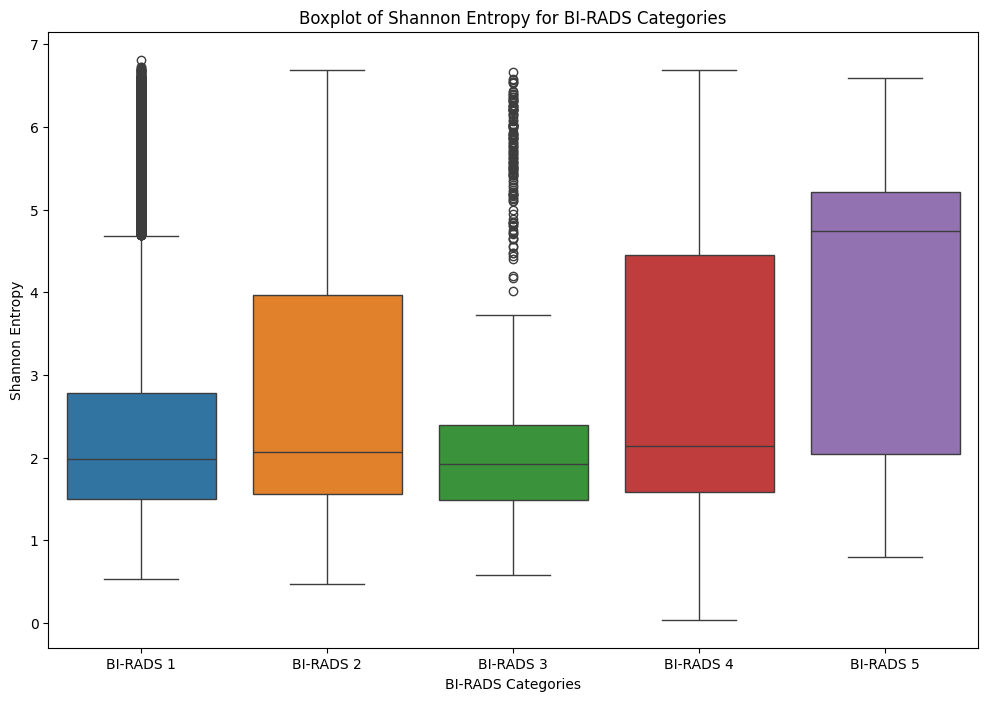

In [15]:
# 3. Krijimi i një DataFrame për entropitë
data_dict = {
    'BI-RADS 1': selected_columns_BLA_br1_entropy,
    'BI-RADS 2': selected_columns_BLA_br2_entropy,
    'BI-RADS 3': selected_columns_BLA_br3_entropy,
    'BI-RADS 4': selected_columns_BLA_br4_entropy,
    'BI-RADS 5': selected_columns_BLA_br5_entropy
}

entropy_df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in data_dict.items()]))

# 4. Ndërtimi i Boxplot-it për të krahasuar entropitë midis kategorive BI-RADS
plt.figure(figsize=(12, 8))
sns.boxplot(data=entropy_df)
plt.title('Boxplot of Shannon Entropy for BI-RADS Categories')
plt.xlabel('BI-RADS Categories')
plt.ylabel('Shannon Entropy')
plt.show()


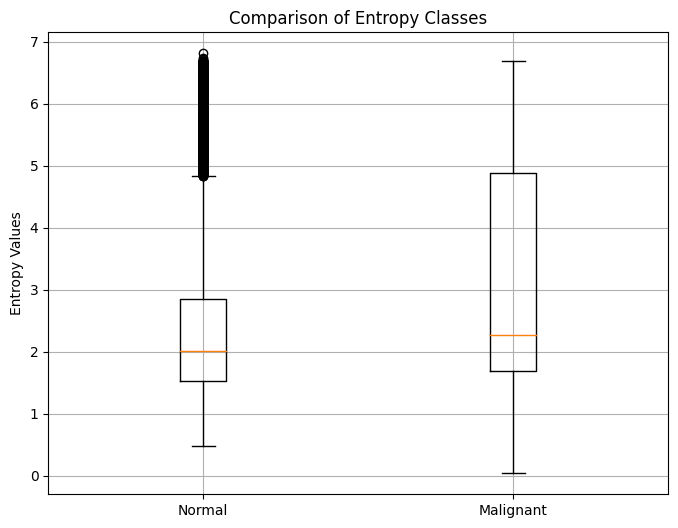

P-Value: 6.867643094786371e-12
Ka një ndryshim domethënës midis dy grupeve.


In [18]:
from scipy.stats import mannwhitneyu
# Krijimi i dy grupeve të bashkuara
entropy_classe_normal = np.concatenate([
    selected_columns_BLA_br1_entropy, 
    selected_columns_BLA_br2_entropy, 
    selected_columns_BLA_br3_entropy
])

entropy_classe_malignant = np.concatenate([
    selected_columns_BLA_br4_entropy, 
    selected_columns_BLA_br5_entropy
])

# Boxplot për krahasim
plt.figure(figsize=(8, 6))
plt.boxplot([entropy_classe_normal, entropy_classe_malignant], labels=['N', 'P'])
plt.ylabel("EPV")
plt.grid(True)
plt.show()

# Llogaritja e p-value me Mann-Whitney U test (jo-parametrik)
stat, p_value = mannwhitneyu(entropy_classe_normal, entropy_classe_malignant, alternative='two-sided')

print(f"P-Value: {p_value}")

# Interpretimi
if p_value < 0.05:
    print("Ka një ndryshim domethënës midis dy grupeve.")
else:
    print("Nuk ka një ndryshim domethënës midis dy grupeve.")

# Tani fusim ne loje edhe nje databaze tjeter:
### Ate te Aranis Saudite

In [ ]:
# Read the CSV file from specifix path in external CD
Saudi_Arabias_data = pd.read_csv(r"E:\PhD\Saudi_Arabia\mammograms\filtered_BIRAD_2_and_causes_without_4images.csv")

print(f'In chinese database we have  {len(Saudi_Arabias_data)}  records')
Saudi_Arabias_data.head(2)

Saudi_Arabias_data_br1 =Saudi_Arabias_data.loc[Saudi_Arabias_data['Assesment'] == 'BIRAD 1']
Saudi_Arabias_data_br2 =Saudi_Arabias_data.loc[Saudi_Arabias_data['Assesment'] == 'BIRAD 2']
Saudi_Arabias_data_br3 =Saudi_Arabias_data.loc[Saudi_Arabias_data['Assesment'] == 'BIRAD 3']
Saudi_Arabias_data_br4 =Saudi_Arabias_data.loc[Saudi_Arabias_data['Assesment'] == 'BIRAD 4']
Saudi_Arabias_data_br5 =Saudi_Arabias_data.loc[Saudi_Arabias_data['Assesment'] == 'BIRAD 5']



In [22]:

# Llogaritja e entropisë për secilën klasë BI-RADS
def calculate_entropy(data, entropy_list, base_path='E:/PhD/Saudi_Arabia/'):
    for i in range(len(data)):
        file_path = Saudi_Arabias_data.iloc[i, 7].replace('.dcm', '.jpg')
        # Construct the full image path
        image_path = os.path.join(base_path, file_path)
        #image = cv2.imread(image_path)
        # Kontrollo nëse ekziston file-i
        print(i)
        if os.path.exists(image_path):
            # Leximi i imazhit
            image = io.imread(image_path, as_gray=True)
            #image = image[:, :, 0]
            #energy_im = energy(image.astype(int))
            
            # Llogaritja e entropisë
            entropy_value = shannon_entropy(image)
            
            # Ruajtja e vlerës në listë
            entropy_list.append(entropy_value)

          

In [ ]:
# Ndarja e klasave BI-RADS nga grupi Mammomat_Inspiration
Saudi_Arabias_data_br1_entropy = []
Saudi_Arabias_data_br2_entropy = []
Saudi_Arabias_data_br3_entropy = []
Saudi_Arabias_data_br4_entropy = []
Saudi_Arabias_data_br5_entropy = []


# Llogarit entropinë për secilën klasë BI-RADS
calculate_entropy(Saudi_Arabias_data_br1, Saudi_Arabias_data_br1_entropy)
calculate_entropy(Saudi_Arabias_data_br2, Saudi_Arabias_data_br2_entropy)
calculate_entropy(Saudi_Arabias_data_br3, Saudi_Arabias_data_br3_entropy)
calculate_entropy(Saudi_Arabias_data_br4, Saudi_Arabias_data_br4_entropy)
calculate_entropy(Saudi_Arabias_data_br5, Saudi_Arabias_data_br5_entropy)

# 3. Krijimi i një DataFrame për entropitë
data_dict = {
    'BI-RADS 1': Saudi_Arabias_data_br1_entropy,
    'BI-RADS 2': Saudi_Arabias_data_br2_entropy,
    'BI-RADS 3': Saudi_Arabias_data_br3_entropy,
    'BI-RADS 4': Saudi_Arabias_data_br4_entropy,
    'BI-RADS 5': Saudi_Arabias_data_br5_entropy
}

entropy_df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in data_dict.items()]))

# 4. Ndërtimi i Boxplot-it për të krahasuar entropitë midis kategorive BI-RADS
plt.figure(figsize=(12, 8))
sns.boxplot(data=entropy_df)
plt.title('Boxplot of Shannon Entropy for BI-RADS Categories for Saudi_Arabias data')
plt.xlabel('BI-RADS Categories')
plt.ylabel('Shannon Entropy')
plt.show()

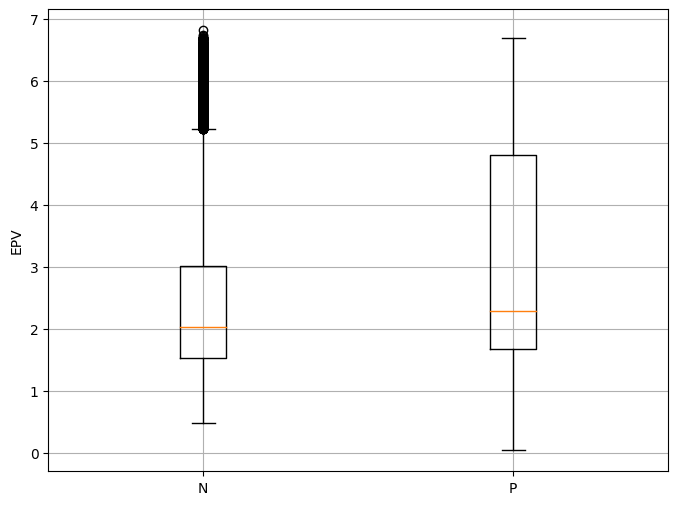

P-Value: 1.5541811640698218e-10
Ka një ndryshim domethënës midis dy grupeve.


In [23]:
from scipy.stats import mannwhitneyu
# Krijimi i dy grupeve të bashkuara

entropy_classe_normal = np.concatenate([
    selected_columns_BLA_br1_entropy, 
    selected_columns_BLA_br2_entropy, 
    selected_columns_BLA_br3_entropy,
    Saudi_Arabias_data_br1_entropy,
    Saudi_Arabias_data_br2_entropy,
    Saudi_Arabias_data_br3_entropy
])

entropy_classe_malignant = np.concatenate([
    selected_columns_BLA_br4_entropy, 
    selected_columns_BLA_br5_entropy,
    Saudi_Arabias_data_br4_entropy,
    Saudi_Arabias_data_br5_entropy
])

# Boxplot për krahasim
plt.figure(figsize=(8, 6))
plt.boxplot([entropy_classe_normal, entropy_classe_malignant], labels=['N', 'P'])
plt.ylabel("EPV")
plt.grid(True)
plt.show()

# Llogaritja e p-value me Mann-Whitney U test (jo-parametrik)
stat, p_value = mannwhitneyu(entropy_classe_normal, entropy_classe_malignant, alternative='two-sided')

print(f"P-Value: {p_value}")

# Interpretimi
if p_value < 0.05:
    print("Ka një ndryshim domethënës midis dy grupeve.")
else:
    print("Nuk ka një ndryshim domethënës midis dy grupeve.")

In [9]:
Mammomat_Inspiration= selected_columns_BLA.loc[metadata["Manufacturer's Model Name"] == 'Mammomat Inspiration']
GIOTTO_IMAGE_3DL= selected_columns_BLA.loc[metadata["Manufacturer's Model Name"] == 'GIOTTO IMAGE 3DL']
Planmed_Nuance= selected_columns_BLA.loc[metadata["Manufacturer's Model Name"] == 'Planmed Nuance']
GIOTTO_CLASS= selected_columns_BLA.loc[metadata["Manufacturer's Model Name"] == 'GIOTTO CLASS']
Planmed_Nuance.head()

,study_id,series_id,image_id,breast_birads,split,laterality,view_position,breast_density
15196,a235482f737d9a3baa8313c8f4db16d6,04537b722941baed999656a0a316c9ea,7e2ac68b81c14f458e7323f2f8951cf2,BI-RADS 4,training,L,MLO,DENSITY C
15197,a235482f737d9a3baa8313c8f4db16d6,04537b722941baed999656a0a316c9ea,6334ea4f303af58784d84f399dae396c,BI-RADS 4,training,L,CC,DENSITY C
15198,a235482f737d9a3baa8313c8f4db16d6,04537b722941baed999656a0a316c9ea,2a3e213d2c7e72a55182ab3cd2e1897c,BI-RADS 2,training,R,MLO,DENSITY C
15199,a235482f737d9a3baa8313c8f4db16d6,04537b722941baed999656a0a316c9ea,328eedacd3e604d5134801aa78f1340c,BI-RADS 2,training,R,CC,DENSITY C
15200,e1314fcdd554aa328145271d19db6929,a076cf0090bcbce5cdf356edf18cf986,86176a5feecb57e582b70cfb87699929,BI-RADS 5,training,L,MLO,DENSITY B


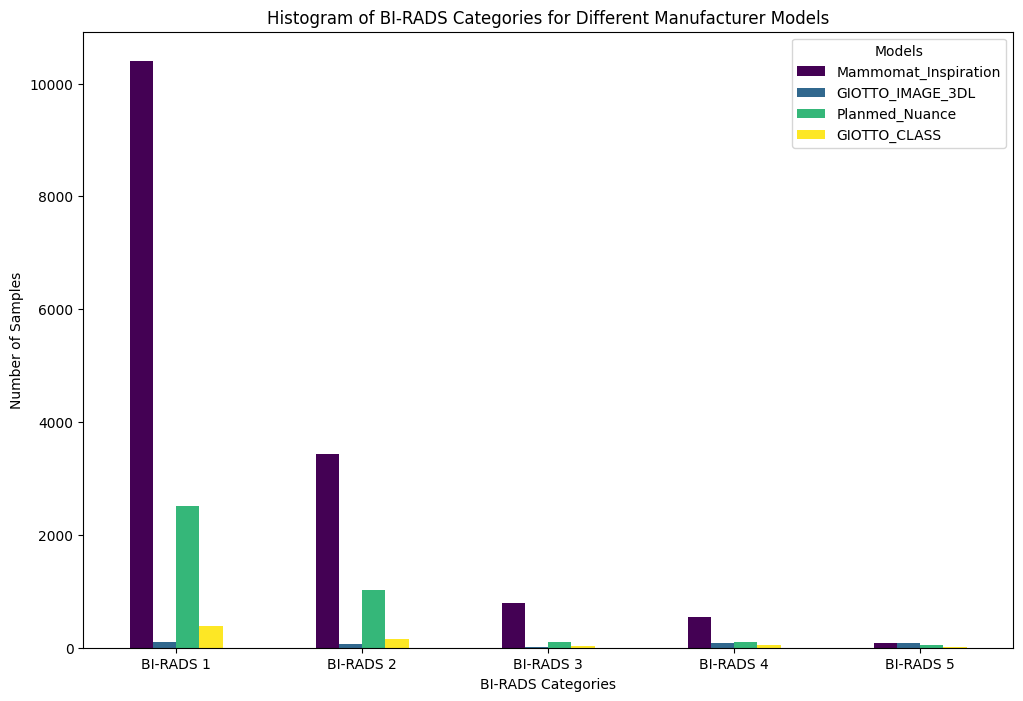

In [12]:

# Numëroni numrin e mostrave për secilën kategori BI-RADS për çdo grup
model_counts = {
    'Mammomat_Inspiration': [
        len(Mammomat_Inspiration_br1), len(Mammomat_Inspiration_br2), 
        len(Mammomat_Inspiration_br3), len(Mammomat_Inspiration_br4), 
        len(Mammomat_Inspiration_br5)
    ],
    'GIOTTO_IMAGE_3DL': [
        len(GIOTTO_IMAGE_3DL_br1), len(GIOTTO_IMAGE_3DL_br2), 
        len(GIOTTO_IMAGE_3DL_br3), len(GIOTTO_IMAGE_3DL_br4), 
        len(GIOTTO_IMAGE_3DL_br5)
    ],
    'Planmed_Nuance': [
        len(Planmed_Nuance_br1), len(Planmed_Nuance_br2), 
        len(Planmed_Nuance_br3), len(Planmed_Nuance_br4), 
        len(Planmed_Nuance_br5)
    ],
    'GIOTTO_CLASS': [
        len(GIOTTO_CLASS_br1), len(GIOTTO_CLASS_br2), 
        len(GIOTTO_CLASS_br3), len(GIOTTO_CLASS_br4), 
        len(GIOTTO_CLASS_br5)
    ]
}

# Krijoni një dataframe për histogramin
br_labels = ['BI-RADS 1', 'BI-RADS 2', 'BI-RADS 3', 'BI-RADS 4', 'BI-RADS 5']
df_hist = pd.DataFrame(model_counts, index=br_labels)

# Ndërtimi i histogramit
df_hist.plot(kind='bar', figsize=(12, 8), colormap='viridis')
plt.xlabel('BI-RADS Categories')
plt.ylabel('Number of Samples')
plt.title('Histogram of BI-RADS Categories for Different Manufacturer Models')
plt.legend(title='Models')
plt.xticks(rotation=0)
plt.show()

In [25]:
Mammomat_Inspiration_br1_1 = Mammomat_Inspiration_br1.iloc[:3200 , :]
Mammomat_Inspiration_br1_1

,study_id,series_id,image_id,breast_birads,split,laterality,view_position,breast_density
4,8269f5971eaca3e5d3772d1796e6bd7a,d931832a0815df082c085b6e09d20aac,dd9ce3288c0773e006a294188aadba8e,BI-RADS 1,training,L,CC,DENSITY C
5,8269f5971eaca3e5d3772d1796e6bd7a,d931832a0815df082c085b6e09d20aac,57fbdd278af5c8789a02b355c11620d4,BI-RADS 1,training,L,MLO,DENSITY C
6,8269f5971eaca3e5d3772d1796e6bd7a,d931832a0815df082c085b6e09d20aac,202d761a6b0f86faaeefc39ee18b1c53,BI-RADS 1,training,R,CC,DENSITY C
7,8269f5971eaca3e5d3772d1796e6bd7a,d931832a0815df082c085b6e09d20aac,acccc1727b61b261844d86aa9de53536,BI-RADS 1,training,R,MLO,DENSITY C
8,fa4dcd0f3ba24e86fc8dc25091f7ebd5,a78f4822d806b4f69ba9f0e0c68778b4,a3d0e2394d7db36afab1b6e5e24da798,BI-RADS 1,training,L,CC,DENSITY C
...,...,...,...,...,...,...,...,...
4647,51c7d1b91a47f5ed5a32f8921d722e71,3e9f646dd5d65bd22f74e74e9af44f11,11d4b789176ae3243c9d9c1d142fa9c9,BI-RADS 1,test,R,MLO,DENSITY C
4654,964092a42ef51df9fa709bec818d70e7,54b60d3e0ecf059c2fe4833f316d7954,f287796450dbb0735c5fe4e0dffb8110,BI-RADS 1,test,R,CC,DENSITY C
4655,964092a42ef51df9fa709bec818d70e7,54b60d3e0ecf059c2fe4833f316d7954,e02ab29b48912c6a45d829b2c657a736,BI-RADS 1,test,R,MLO,DENSITY C
4660,532a837f8da94d01ba959e9d828ed368,be0bf67957942c5e5cfd7036d5c83b09,42c6df978f350bc54583b16cb31953f7,BI-RADS 1,test,L,CC,DENSITY D


In [26]:
selected_columns_BLA_br1 = selected_columns_BLA.loc[selected_columns_BLA['breast_birads'] == 'BI-RADS 1']
selected_columns_BLA_br2 = selected_columns_BLA.loc[selected_columns_BLA['breast_birads'] == 'BI-RADS 2']
selected_columns_BLA_br3 = selected_columns_BLA.loc[selected_columns_BLA['breast_birads'] == 'BI-RADS 3']
selected_columns_BLA_br4 = selected_columns_BLA.loc[selected_columns_BLA['breast_birads'] == 'BI-RADS 4']
selected_columns_BLA_br5 = selected_columns_BLA.loc[selected_columns_BLA['breast_birads'] == 'BI-RADS 5']


In [27]:

# Llogaritja e entropisë për secilën klasë BI-RADS
def calculate_entropy(data, entropy_list, base_path='E:/PhD/V_M_Dataset/images/'):
    for i in range(len(data)):
        image_id = data.iloc[i, 0]  # Merre ID-në e imazhit nga kolona e parë
        image_folder = data.iloc[i, 0]  # Marrim emrin e folderit ku ndodhet imazhi
        image_name = data.iloc[i, 2]  # Merre emrin e imazhit nga kolona e tretë (nëse është ndryshe, ndryshoje këtu)
        
        # Ndërtimi i path-it të plotë për imazhin
        image_path = os.path.join(base_path, image_folder, f'{image_name}.dicom.jpg')
        
        # Kontrollo nëse ekziston file-i
        if os.path.exists(image_path):
            # Leximi i imazhit
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            if len(image.shape) == 3:
                image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
            energy_im = energy(image.astype(int))
            
            # Llogaritja e entropisë
            entropy_value = shannon_entropy(energy_im)
            
            # Ruajtja e vlerës në listë
            entropy_list.append(entropy_value)

          

filloj grupi me i madhe
mbaroj grupi me i madhe


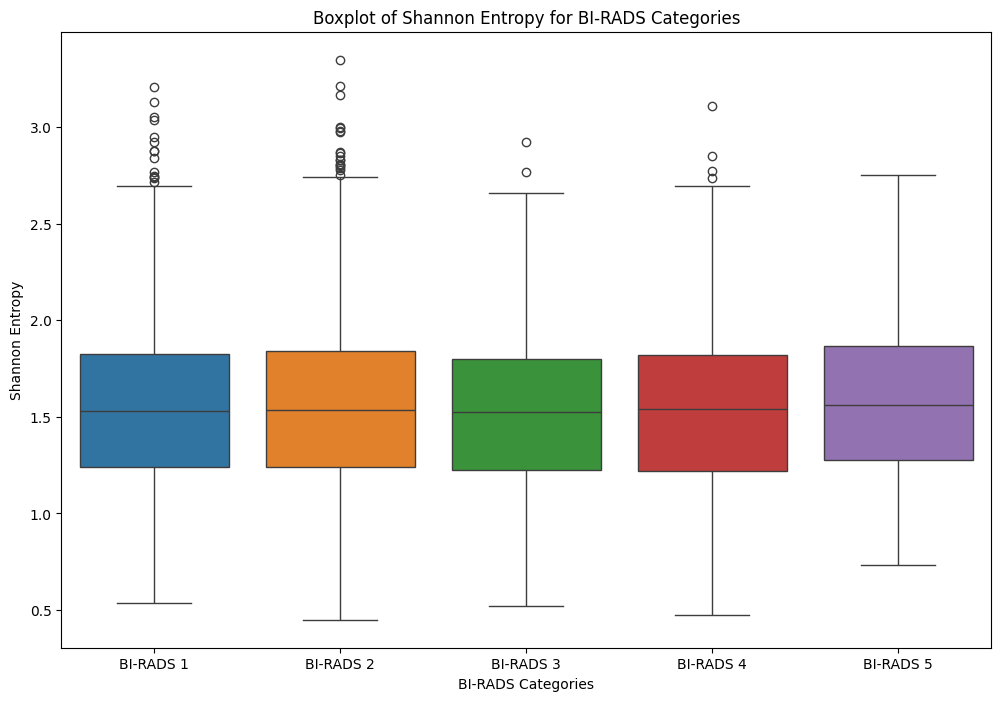

In [28]:

# Ndarja e klasave BI-RADS nga grupi Mammomat_Inspiration
Mammomat_Inspiration_br1_entropy = []
Mammomat_Inspiration_br2_entropy = []
Mammomat_Inspiration_br3_entropy = []
Mammomat_Inspiration_br4_entropy = []
Mammomat_Inspiration_br5_entropy = []

# Llogarit entropinë për secilën klasë BI-RADS
Mammomat_Inspiration_br1_1 = Mammomat_Inspiration_br1.iloc[:3200 , :]
print('filloj grupi me i madhe')
calculate_entropy(Mammomat_Inspiration_br1_1, Mammomat_Inspiration_br1_entropy)
print('mbaroj grupi me i madhe')
calculate_entropy(Mammomat_Inspiration_br2, Mammomat_Inspiration_br2_entropy)
calculate_entropy(Mammomat_Inspiration_br3, Mammomat_Inspiration_br3_entropy)
calculate_entropy(Mammomat_Inspiration_br4, Mammomat_Inspiration_br4_entropy)
calculate_entropy(Mammomat_Inspiration_br5, Mammomat_Inspiration_br5_entropy)

# 3. Krijimi i një DataFrame për entropitë
data_dict = {
    'BI-RADS 1': Mammomat_Inspiration_br1_entropy,
    'BI-RADS 2': Mammomat_Inspiration_br2_entropy,
    'BI-RADS 3': Mammomat_Inspiration_br3_entropy,
    'BI-RADS 4': Mammomat_Inspiration_br4_entropy,
    'BI-RADS 5': Mammomat_Inspiration_br5_entropy
}

entropy_df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in data_dict.items()]))

# 4. Ndërtimi i Boxplot-it për të krahasuar entropitë midis kategorive BI-RADS
plt.figure(figsize=(12, 8))
sns.boxplot(data=entropy_df)
plt.title('Boxplot of Shannon Entropy for BI-RADS Categories')
plt.xlabel('BI-RADS Categories')
plt.ylabel('Shannon Entropy')
plt.show()


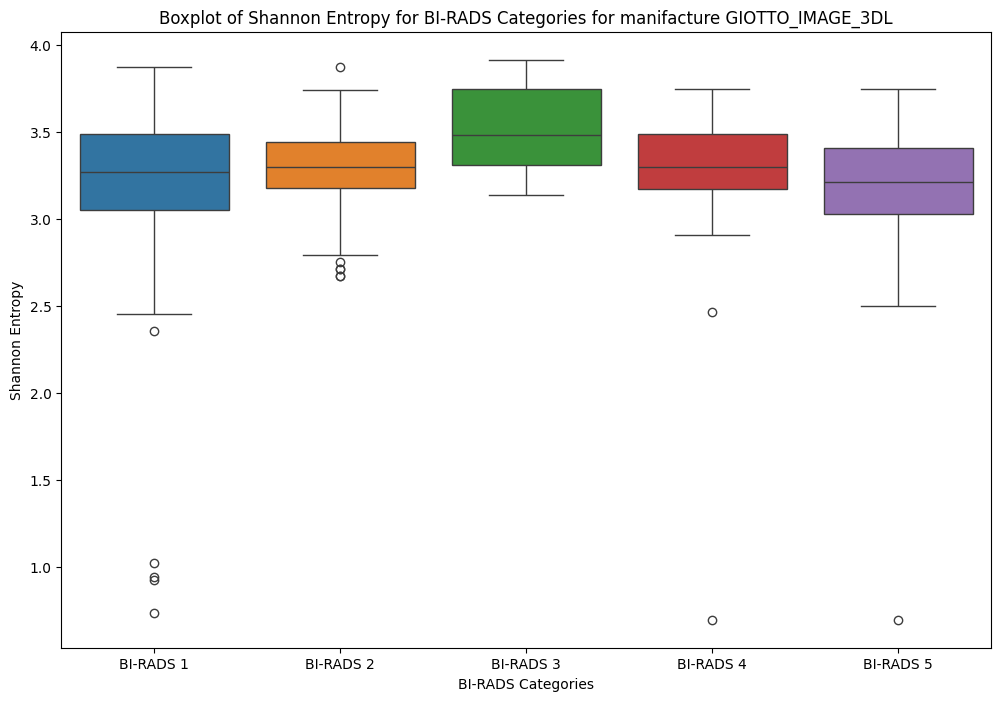

In [29]:
# Ndarja e klasave BI-RADS nga grupi Mammomat_Inspiration
GIOTTO_IMAGE_3DL_br1_entropy = []
GIOTTO_IMAGE_3DL_br2_entropy = []
GIOTTO_IMAGE_3DL_br3_entropy = []
GIOTTO_IMAGE_3DL_br4_entropy = []
GIOTTO_IMAGE_3DL_br5_entropy = []

# Llogarit entropinë për secilën klasë BI-RADS
calculate_entropy(GIOTTO_IMAGE_3DL_br1, GIOTTO_IMAGE_3DL_br1_entropy)
calculate_entropy(GIOTTO_IMAGE_3DL_br2, GIOTTO_IMAGE_3DL_br2_entropy)
calculate_entropy(GIOTTO_IMAGE_3DL_br3, GIOTTO_IMAGE_3DL_br3_entropy)
calculate_entropy(GIOTTO_IMAGE_3DL_br4, GIOTTO_IMAGE_3DL_br4_entropy)
calculate_entropy(GIOTTO_IMAGE_3DL_br5, GIOTTO_IMAGE_3DL_br5_entropy)

# 3. Krijimi i një DataFrame për entropitë
data_dict = {
    'BI-RADS 1': GIOTTO_IMAGE_3DL_br1_entropy,
    'BI-RADS 2': GIOTTO_IMAGE_3DL_br2_entropy,
    'BI-RADS 3': GIOTTO_IMAGE_3DL_br3_entropy,
    'BI-RADS 4': GIOTTO_IMAGE_3DL_br4_entropy,
    'BI-RADS 5': GIOTTO_IMAGE_3DL_br5_entropy
}

entropy_df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in data_dict.items()]))

# 4. Ndërtimi i Boxplot-it për të krahasuar entropitë midis kategorive BI-RADS
plt.figure(figsize=(12, 8))
sns.boxplot(data=entropy_df)
plt.title('Boxplot of Shannon Entropy for BI-RADS Categories for manifacture GIOTTO_IMAGE_3DL')
plt.xlabel('BI-RADS Categories')
plt.ylabel('Shannon Entropy')
plt.show()


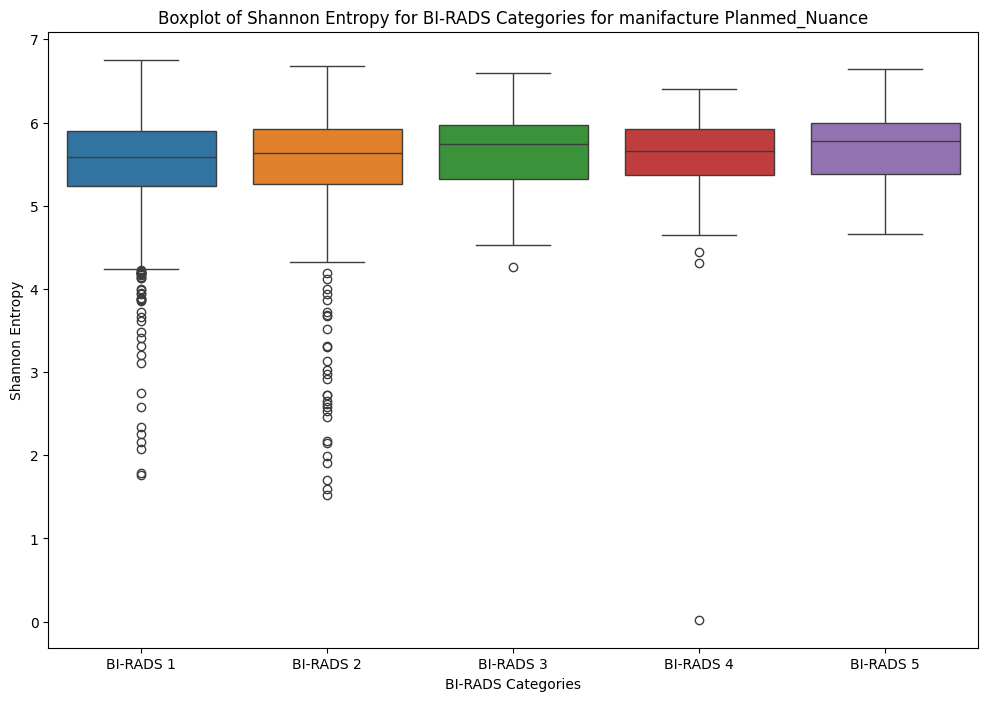

In [30]:
# Ndarja e klasave BI-RADS nga grupi Mammomat_Inspiration
Planmed_Nuance_br1_entropy = []
Planmed_Nuance_br2_entropy = []
Planmed_Nuance_br3_entropy = []
Planmed_Nuance_br4_entropy = []
Planmed_Nuance_br5_entropy = []

# Llogarit entropinë për secilën klasë BI-RADS
calculate_entropy(Planmed_Nuance_br1, Planmed_Nuance_br1_entropy)
calculate_entropy(Planmed_Nuance_br2, Planmed_Nuance_br2_entropy)
calculate_entropy(Planmed_Nuance_br3, Planmed_Nuance_br3_entropy)
calculate_entropy(Planmed_Nuance_br4, Planmed_Nuance_br4_entropy)
calculate_entropy(Planmed_Nuance_br5, Planmed_Nuance_br5_entropy)

# 3. Krijimi i një DataFrame për entropitë
data_dict = {
    'BI-RADS 1': Planmed_Nuance_br1_entropy,
    'BI-RADS 2': Planmed_Nuance_br2_entropy,
    'BI-RADS 3': Planmed_Nuance_br3_entropy,
    'BI-RADS 4': Planmed_Nuance_br4_entropy,
    'BI-RADS 5': Planmed_Nuance_br5_entropy
}

entropy_df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in data_dict.items()]))

# 4. Ndërtimi i Boxplot-it për të krahasuar entropitë midis kategorive BI-RADS
plt.figure(figsize=(12, 8))
sns.boxplot(data=entropy_df)
plt.title('Boxplot of Shannon Entropy for BI-RADS Categories for manifacture Planmed_Nuance')
plt.xlabel('BI-RADS Categories')
plt.ylabel('Shannon Entropy')
plt.show()


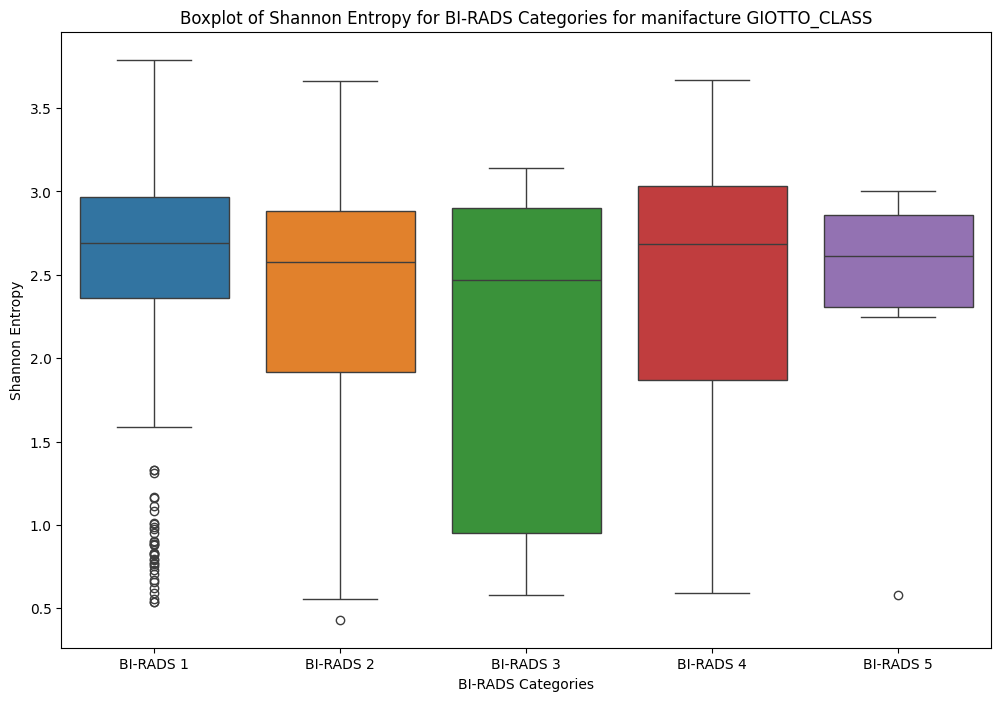

In [31]:
# Ndarja e klasave BI-RADS nga grupi Mammomat_Inspiration
GIOTTO_CLASS_br1_entropy = []
GIOTTO_CLASS_br2_entropy = []
GIOTTO_CLASS_br3_entropy = []
GIOTTO_CLASS_br4_entropy = []
GIOTTO_CLASS_br5_entropy = []


# Llogarit entropinë për secilën klasë BI-RADS
calculate_entropy(GIOTTO_CLASS_br1, GIOTTO_CLASS_br1_entropy)
calculate_entropy(GIOTTO_CLASS_br2, GIOTTO_CLASS_br2_entropy)
calculate_entropy(GIOTTO_CLASS_br3, GIOTTO_CLASS_br3_entropy)
calculate_entropy(GIOTTO_CLASS_br4, GIOTTO_CLASS_br4_entropy)
calculate_entropy(GIOTTO_CLASS_br5, GIOTTO_CLASS_br5_entropy)

# 3. Krijimi i një DataFrame për entropitë
data_dict = {
    'BI-RADS 1': GIOTTO_CLASS_br1_entropy,
    'BI-RADS 2': GIOTTO_CLASS_br2_entropy,
    'BI-RADS 3': GIOTTO_CLASS_br3_entropy,
    'BI-RADS 4': GIOTTO_CLASS_br4_entropy,
    'BI-RADS 5': GIOTTO_CLASS_br5_entropy
}

entropy_df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in data_dict.items()]))

# 4. Ndërtimi i Boxplot-it për të krahasuar entropitë midis kategorive BI-RADS
plt.figure(figsize=(12, 8))
sns.boxplot(data=entropy_df)
plt.title('Boxplot of Shannon Entropy for BI-RADS Categories for manifacture GIOTTO_CLASS')
plt.xlabel('BI-RADS Categories')
plt.ylabel('Shannon Entropy')
plt.show()


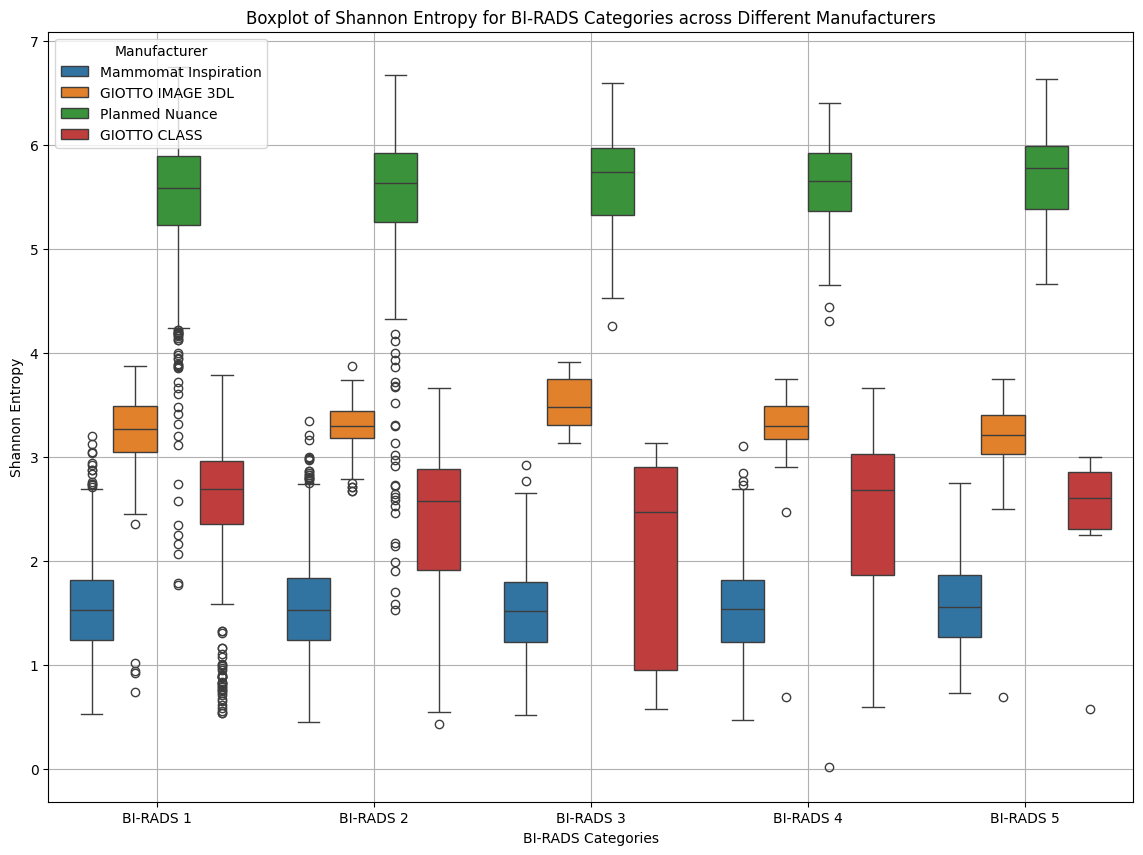

In [32]:
data_dict_1 = {
    'BI-RADS 1': Mammomat_Inspiration_br1_entropy,
    'BI-RADS 2': Mammomat_Inspiration_br2_entropy,
    'BI-RADS 3': Mammomat_Inspiration_br3_entropy,
    'BI-RADS 4': Mammomat_Inspiration_br4_entropy,
    'BI-RADS 5': Mammomat_Inspiration_br5_entropy
}

data_dict_2 = {
    'BI-RADS 1': GIOTTO_IMAGE_3DL_br1_entropy,
    'BI-RADS 2': GIOTTO_IMAGE_3DL_br2_entropy,
    'BI-RADS 3': GIOTTO_IMAGE_3DL_br3_entropy,
    'BI-RADS 4': GIOTTO_IMAGE_3DL_br4_entropy,
    'BI-RADS 5': GIOTTO_IMAGE_3DL_br5_entropy
}

data_dict_3 = {
    'BI-RADS 1': Planmed_Nuance_br1_entropy,
    'BI-RADS 2': Planmed_Nuance_br2_entropy,
    'BI-RADS 3': Planmed_Nuance_br3_entropy,
    'BI-RADS 4': Planmed_Nuance_br4_entropy,
    'BI-RADS 5': Planmed_Nuance_br5_entropy
}

data_dict_4 = {
    'BI-RADS 1': GIOTTO_CLASS_br1_entropy,
    'BI-RADS 2': GIOTTO_CLASS_br2_entropy,
    'BI-RADS 3': GIOTTO_CLASS_br3_entropy,
    'BI-RADS 4': GIOTTO_CLASS_br4_entropy,
    'BI-RADS 5': GIOTTO_CLASS_br5_entropy
}



# Kombino entropinë për secilin BI-RADS nga prodhues të ndryshëm në një DataFrame të përbashkët
combined_data = {
    'Entropy': [],  # Vlerat e entropisë
    'BI-RADS Category': [],  # Kategoria BI-RADS (1, 2, 3, 4, 5)
    'Manufacturer': []  # Prodhuesi (Mammomat, GIOTTO_IMAGE_3DL, Planmed, GIOTTO_CLASS)
}

# Shto të dhënat për secilën kategori të `Mammomat_Inspiration`
for category, values in data_dict_1.items():
    combined_data['Entropy'].extend(values)
    combined_data['BI-RADS Category'].extend([category] * len(values))
    combined_data['Manufacturer'].extend(['Mammomat Inspiration'] * len(values))

# Shto të dhënat për secilën kategori të `GIOTTO_IMAGE_3DL`
for category, values in data_dict_2.items():
    combined_data['Entropy'].extend(values)
    combined_data['BI-RADS Category'].extend([category] * len(values))
    combined_data['Manufacturer'].extend(['GIOTTO IMAGE 3DL'] * len(values))

# Shto të dhënat për secilën kategori të `Planmed_Nuance`
for category, values in data_dict_3.items():
    combined_data['Entropy'].extend(values)
    combined_data['BI-RADS Category'].extend([category] * len(values))
    combined_data['Manufacturer'].extend(['Planmed Nuance'] * len(values))

# Shto të dhënat për secilën kategori të `GIOTTO_CLASS`
for category, values in data_dict_4.items():
    combined_data['Entropy'].extend(values)
    combined_data['BI-RADS Category'].extend([category] * len(values))
    combined_data['Manufacturer'].extend(['GIOTTO CLASS'] * len(values))

# Krijo DataFrame për të gjitha të dhënat
combined_df = pd.DataFrame(combined_data)

# Ndërtimi i një boxplot të vetëm për të gjitha kategoritë dhe prodhuesit
plt.figure(figsize=(14, 10))
sns.boxplot(x='BI-RADS Category', y='Entropy', hue='Manufacturer', data=combined_df)
plt.title('Boxplot of Shannon Entropy for BI-RADS Categories across Different Manufacturers')
plt.xlabel('BI-RADS Categories')
plt.ylabel('Shannon Entropy')
plt.legend(title='Manufacturer')
plt.grid(True)
plt.show()



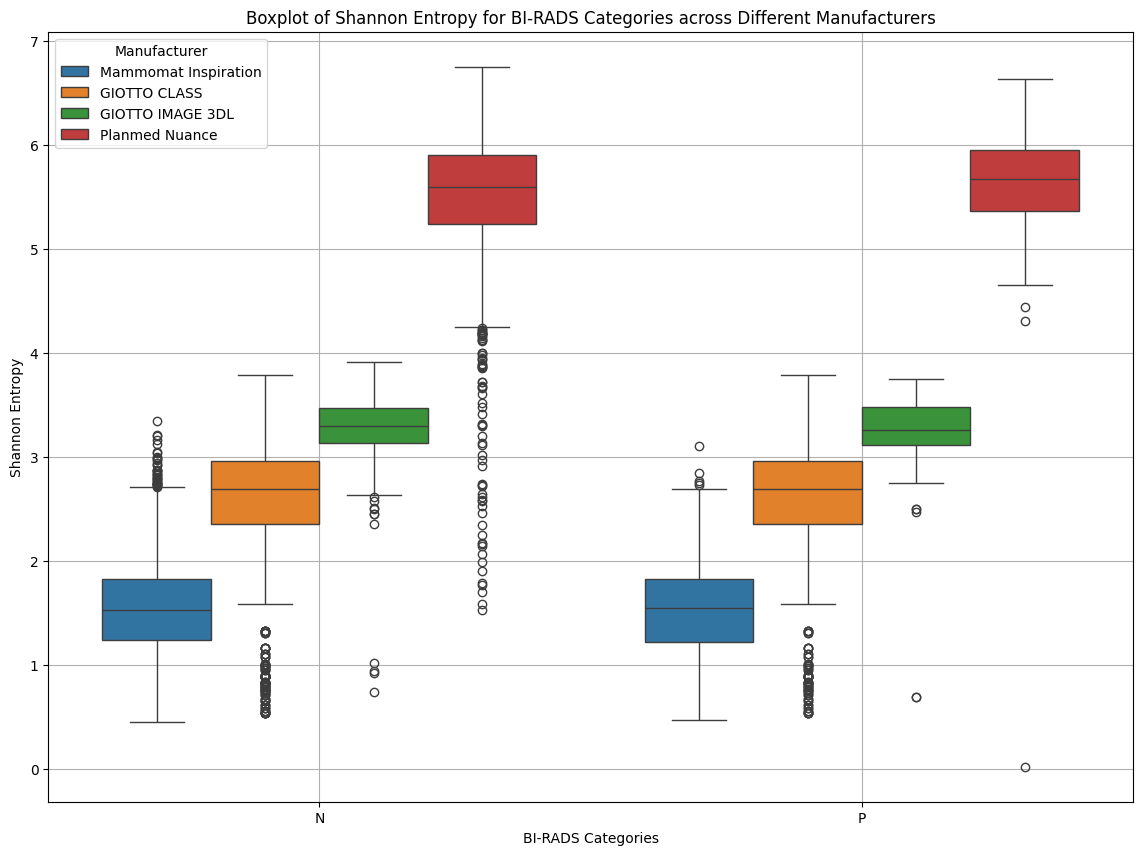

In [34]:
data_dict_1 = {
    'N': np.concatenate([Mammomat_Inspiration_br1_entropy,
                         Mammomat_Inspiration_br2_entropy,
                         Mammomat_Inspiration_br3_entropy]),
    'P': np.concatenate([Mammomat_Inspiration_br4_entropy,
                         Mammomat_Inspiration_br5_entropy])
}

data_dict_2 = {
    'N': np.concatenate([GIOTTO_IMAGE_3DL_br1_entropy,
                         GIOTTO_IMAGE_3DL_br2_entropy,
                         GIOTTO_IMAGE_3DL_br3_entropy]),
    'P': np.concatenate([GIOTTO_IMAGE_3DL_br4_entropy,
                         GIOTTO_IMAGE_3DL_br5_entropy])
}

data_dict_3 = {
    'N': np.concatenate([Planmed_Nuance_br1_entropy,
                         Planmed_Nuance_br2_entropy,
                         Planmed_Nuance_br3_entropy]),
    'P': np.concatenate([Planmed_Nuance_br4_entropy,
                         Planmed_Nuance_br5_entropy])
}

data_dict_4 = {
    'N': np.concatenate([GIOTTO_CLASS_br1_entropy,
                         GIOTTO_CLASS_br1_entropy,
                         GIOTTO_CLASS_br1_entropy]),
    'P': np.concatenate([GIOTTO_CLASS_br1_entropy,
                         GIOTTO_CLASS_br1_entropy])
}



# Kombino entropinë për secilin BI-RADS nga prodhues të ndryshëm në një DataFrame të përbashkët
combined_data = {
    'Entropy': [],  # Vlerat e entropisë
    'BI-RADS Category': [],  # Kategoria BI-RADS (1, 2, 3, 4, 5)
    'Manufacturer': []  # Prodhuesi (Mammomat, GIOTTO_IMAGE_3DL, Planmed, GIOTTO_CLASS)
}

# Shto të dhënat për secilën kategori të `Mammomat_Inspiration`
for category, values in data_dict_1.items():
    combined_data['Entropy'].extend(values)
    combined_data['BI-RADS Category'].extend([category] * len(values))
    combined_data['Manufacturer'].extend(['Mammomat Inspiration'] * len(values))
    
# Shto të dhënat për secilën kategori të `GIOTTO_CLASS`
for category, values in data_dict_4.items():
    combined_data['Entropy'].extend(values)
    combined_data['BI-RADS Category'].extend([category] * len(values))
    combined_data['Manufacturer'].extend(['GIOTTO CLASS'] * len(values))


# Shto të dhënat për secilën kategori të `GIOTTO_IMAGE_3DL`
for category, values in data_dict_2.items():
    combined_data['Entropy'].extend(values)
    combined_data['BI-RADS Category'].extend([category] * len(values))
    combined_data['Manufacturer'].extend(['GIOTTO IMAGE 3DL'] * len(values))

# Shto të dhënat për secilën kategori të `Planmed_Nuance`
for category, values in data_dict_3.items():
    combined_data['Entropy'].extend(values)
    combined_data['BI-RADS Category'].extend([category] * len(values))
    combined_data['Manufacturer'].extend(['Planmed Nuance'] * len(values))


# Krijo DataFrame për të gjitha të dhënat
combined_df = pd.DataFrame(combined_data)

# Ndërtimi i një boxplot të vetëm për të gjitha kategoritë dhe prodhuesit
plt.figure(figsize=(14, 10))
sns.boxplot(x='BI-RADS Category', y='Entropy', hue='Manufacturer', data=combined_df)
plt.title('Boxplot of Shannon Entropy for BI-RADS Categories across Different Manufacturers')
plt.xlabel('BI-RADS Categories')
plt.ylabel('Shannon Entropy')
plt.legend(title='Manufacturer')
plt.grid(True)
plt.show()



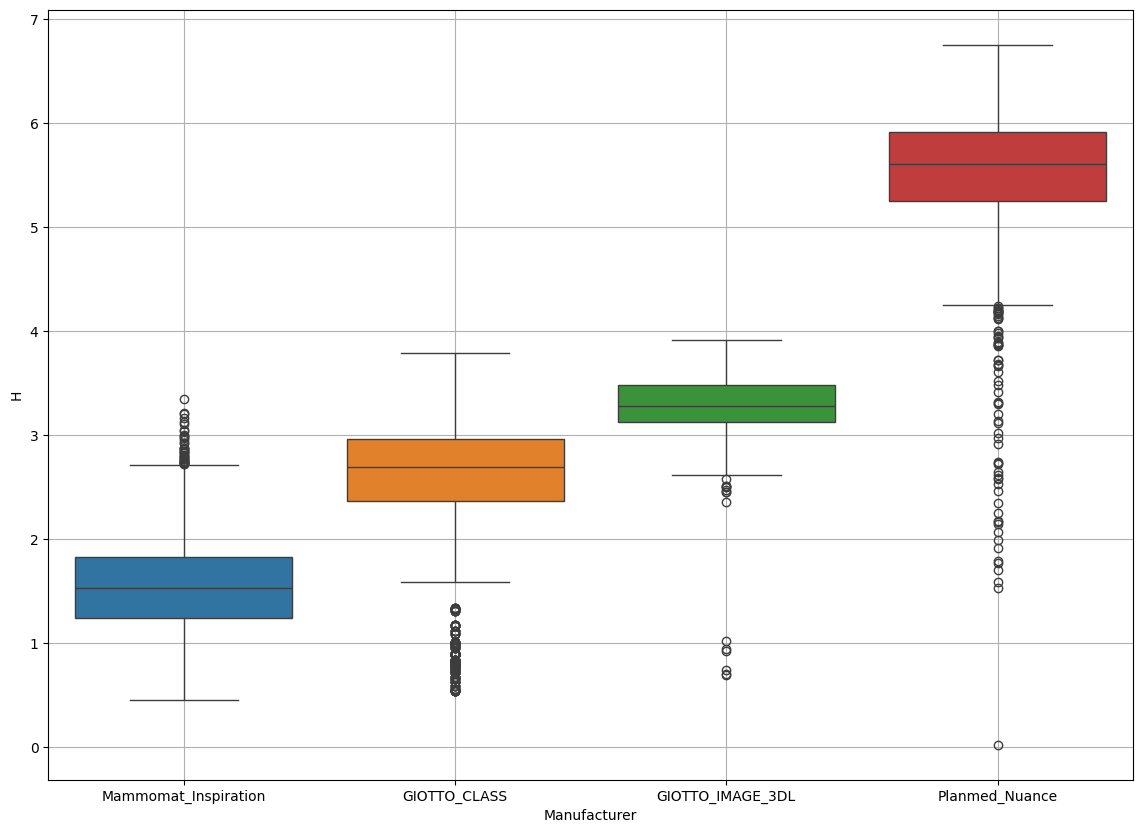

In [37]:
data_dict_1 = {
    'Mammomat_Inspiration': np.concatenate([Mammomat_Inspiration_br1_entropy,
                         Mammomat_Inspiration_br2_entropy,
                         Mammomat_Inspiration_br3_entropy,
                         Mammomat_Inspiration_br4_entropy,
                         Mammomat_Inspiration_br5_entropy])
}

data_dict_2 = {
    'GIOTTO_IMAGE_3DL': np.concatenate([GIOTTO_IMAGE_3DL_br1_entropy,
                         GIOTTO_IMAGE_3DL_br2_entropy,
                         GIOTTO_IMAGE_3DL_br3_entropy,
                         GIOTTO_IMAGE_3DL_br4_entropy,
                         GIOTTO_IMAGE_3DL_br5_entropy])
}

data_dict_3 = {
    'Planmed_Nuance': np.concatenate([Planmed_Nuance_br1_entropy,
                         Planmed_Nuance_br2_entropy,
                         Planmed_Nuance_br3_entropy,
                         Planmed_Nuance_br4_entropy,
                         Planmed_Nuance_br5_entropy])
}

data_dict_4 = {
    'GIOTTO_CLASS': np.concatenate([GIOTTO_CLASS_br1_entropy,
                         GIOTTO_CLASS_br1_entropy,
                         GIOTTO_CLASS_br1_entropy,
                         GIOTTO_CLASS_br1_entropy,
                         GIOTTO_CLASS_br1_entropy])
}



# Kombino entropinë për secilin BI-RADS nga prodhues të ndryshëm në një DataFrame të përbashkët
combined_data = {
    'Entropy': [],  # Vlerat e entropisë
    'BI-RADS Category': [],  # Kategoria BI-RADS (1, 2, 3, 4, 5)
    'Manufacturer': []  # Prodhuesi (Mammomat, GIOTTO_IMAGE_3DL, Planmed, GIOTTO_CLASS)
}

# Shto të dhënat për secilën kategori të `Mammomat_Inspiration`
for category, values in data_dict_1.items():
    combined_data['Entropy'].extend(values)
    combined_data['BI-RADS Category'].extend([category] * len(values))
    combined_data['Manufacturer'].extend(['Mammomat Inspiration'] * len(values))
    
# Shto të dhënat për secilën kategori të `GIOTTO_CLASS`
for category, values in data_dict_4.items():
    combined_data['Entropy'].extend(values)
    combined_data['BI-RADS Category'].extend([category] * len(values))
    combined_data['Manufacturer'].extend(['GIOTTO CLASS'] * len(values))


# Shto të dhënat për secilën kategori të `GIOTTO_IMAGE_3DL`
for category, values in data_dict_2.items():
    combined_data['Entropy'].extend(values)
    combined_data['BI-RADS Category'].extend([category] * len(values))
    combined_data['Manufacturer'].extend(['GIOTTO IMAGE 3DL'] * len(values))

# Shto të dhënat për secilën kategori të `Planmed_Nuance`
for category, values in data_dict_3.items():
    combined_data['Entropy'].extend(values)
    combined_data['BI-RADS Category'].extend([category] * len(values))
    combined_data['Manufacturer'].extend(['Planmed Nuance'] * len(values))


# Krijo DataFrame për të gjitha të dhënat
combined_df = pd.DataFrame(combined_data)

# Ndërtimi i një boxplot të vetëm për të gjitha kategoritë dhe prodhuesit
plt.figure(figsize=(14, 10))
sns.boxplot(x='BI-RADS Category', y='Entropy', hue='Manufacturer', data=combined_df)
plt.xlabel('Manufacturer')
plt.ylabel('H')
plt.legend().remove()  # This removes the legend
plt.grid(True)
plt.show()



In [38]:
# Saudi arabia dataset
Saudi_Arabias_data = pd.read_csv(r"E:\PhD\Saudi_Arabia\mammograms\filtered_BIRAD_2_and_causes_without_4images.csv")

print(f'In chinese database we have  {len(Saudi_Arabias_data)}  records')
Saudi_Arabias_data.head(2)

Saudi_Arabias_data_br1 =Saudi_Arabias_data.loc[Saudi_Arabias_data['Assesment'] == 'BIRAD 1']
Saudi_Arabias_data_br2 =Saudi_Arabias_data.loc[Saudi_Arabias_data['Assesment'] == 'BIRAD 2']
Saudi_Arabias_data_br3 =Saudi_Arabias_data.loc[Saudi_Arabias_data['Assesment'] == 'BIRAD 3']
Saudi_Arabias_data_br4 =Saudi_Arabias_data.loc[Saudi_Arabias_data['Assesment'] == 'BIRAD 4']
Saudi_Arabias_data_br5 =Saudi_Arabias_data.loc[Saudi_Arabias_data['Assesment'] == 'BIRAD 5']



In chinese database we have  1344  records


In [39]:

# Llogaritja e entropisë për secilën klasë BI-RADS
def calculate_entropy(data, entropy_list, base_path='E:/PhD/Saudi_Arabia/'):
    for i in range(len(data)):
        file_path = Saudi_Arabias_data.iloc[i, 7].replace('.dcm', '.jpg')
        # Construct the full image path
        base_path='E:/PhD/Saudi_Arabia/
        image_path = os.path.join(base_path, file_path)
        #image = cv2.imread(image_path)
        # Kontrollo nëse ekziston file-i
        print(i)
        if os.path.exists(image_path):
            # Leximi i imazhit
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            if len(image.shape) == 3:
                image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
            energy_im = energy(image.astype(int))
            
            # Llogaritja e entropisë
            entropy_value = shannon_entropy(energy_im)
            
            # Ruajtja e vlerës në listë
            entropy_list.append(entropy_value)

          

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

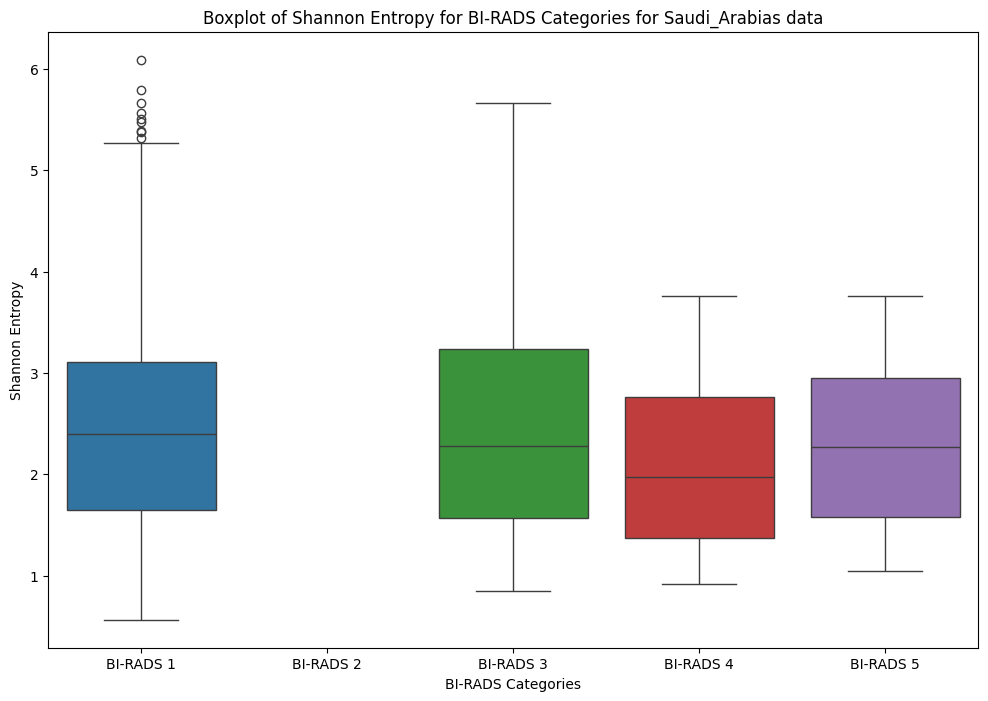

In [40]:
# Ndarja e klasave BI-RADS nga grupi Mammomat_Inspiration
Saudi_Arabias_data_br1_entropy = []
Saudi_Arabias_data_br2_entropy = []
Saudi_Arabias_data_br3_entropy = []
Saudi_Arabias_data_br4_entropy = []
Saudi_Arabias_data_br5_entropy = []


# Llogarit entropinë për secilën klasë BI-RADS
calculate_entropy(Saudi_Arabias_data_br1, Saudi_Arabias_data_br1_entropy)
calculate_entropy(Saudi_Arabias_data_br2, Saudi_Arabias_data_br2_entropy)
calculate_entropy(Saudi_Arabias_data_br3, Saudi_Arabias_data_br3_entropy)
calculate_entropy(Saudi_Arabias_data_br4, Saudi_Arabias_data_br4_entropy)
calculate_entropy(Saudi_Arabias_data_br5, Saudi_Arabias_data_br5_entropy)

# 3. Krijimi i një DataFrame për entropitë
data_dict = {
    'BI-RADS 1': Saudi_Arabias_data_br1_entropy,
    'BI-RADS 2': Saudi_Arabias_data_br2_entropy,
    'BI-RADS 3': Saudi_Arabias_data_br3_entropy,
    'BI-RADS 4': Saudi_Arabias_data_br4_entropy,
    'BI-RADS 5': Saudi_Arabias_data_br5_entropy
}

entropy_df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in data_dict.items()]))

# 4. Ndërtimi i Boxplot-it për të krahasuar entropitë midis kategorive BI-RADS
plt.figure(figsize=(12, 8))
sns.boxplot(data=entropy_df)
plt.title('Boxplot of Shannon Entropy for BI-RADS Categories for Saudi_Arabias data')
plt.xlabel('BI-RADS Categories')
plt.ylabel('Shannon Entropy')
plt.show()

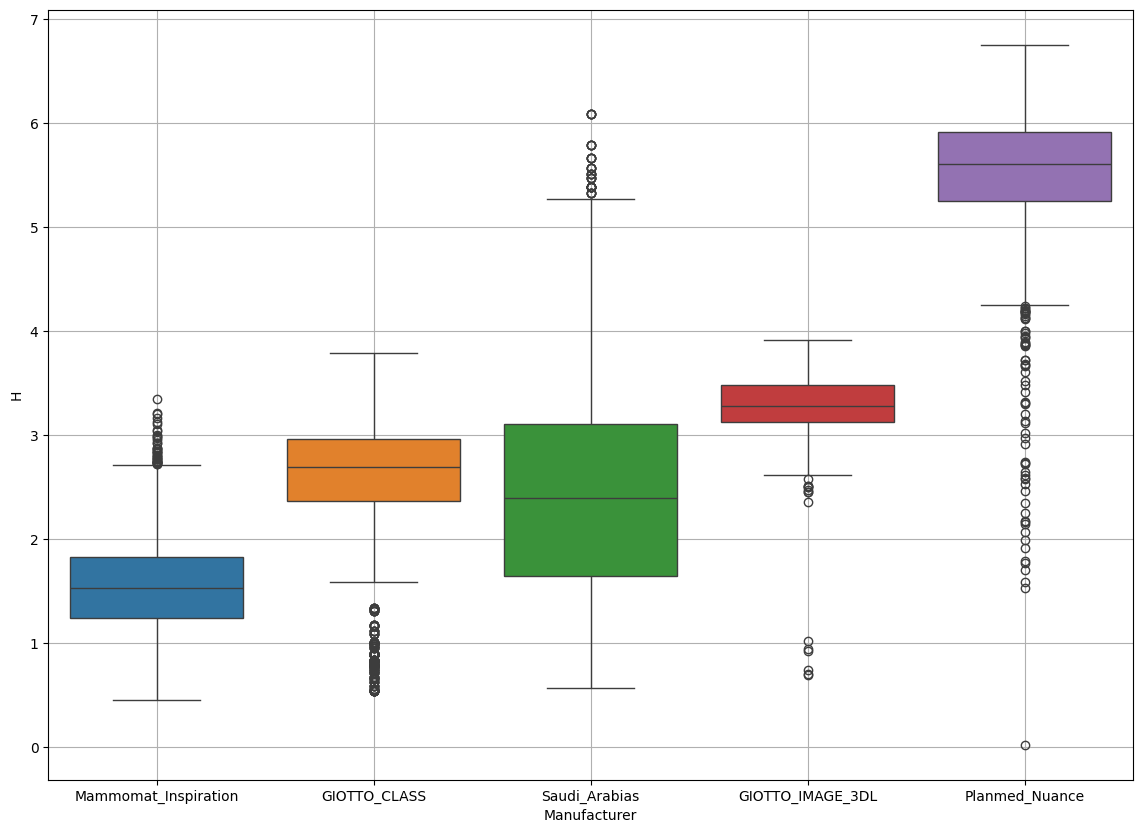

In [42]:
data_dict_1 = {
    'Mammomat_Inspiration': np.concatenate([Mammomat_Inspiration_br1_entropy,
                         Mammomat_Inspiration_br2_entropy,
                         Mammomat_Inspiration_br3_entropy,
                         Mammomat_Inspiration_br4_entropy,
                         Mammomat_Inspiration_br5_entropy])
}

data_dict_2 = {
    'GIOTTO_IMAGE_3DL': np.concatenate([GIOTTO_IMAGE_3DL_br1_entropy,
                         GIOTTO_IMAGE_3DL_br2_entropy,
                         GIOTTO_IMAGE_3DL_br3_entropy,
                         GIOTTO_IMAGE_3DL_br4_entropy,
                         GIOTTO_IMAGE_3DL_br5_entropy])
}

data_dict_3 = {
    'Planmed_Nuance': np.concatenate([Planmed_Nuance_br1_entropy,
                         Planmed_Nuance_br2_entropy,
                         Planmed_Nuance_br3_entropy,
                         Planmed_Nuance_br4_entropy,
                         Planmed_Nuance_br5_entropy])
}

data_dict_4 = {
    'GIOTTO_CLASS': np.concatenate([GIOTTO_CLASS_br1_entropy,
                         GIOTTO_CLASS_br1_entropy,
                         GIOTTO_CLASS_br1_entropy,
                         GIOTTO_CLASS_br1_entropy,
                         GIOTTO_CLASS_br1_entropy])
}

data_dict_5 = {
    'Saudi_Arabias': np.concatenate([Saudi_Arabias_data_br1_entropy,
                         Saudi_Arabias_data_br1_entropy,
                         Saudi_Arabias_data_br1_entropy,
                         Saudi_Arabias_data_br1_entropy,
                         Saudi_Arabias_data_br1_entropy])
}



# Kombino entropinë për secilin BI-RADS nga prodhues të ndryshëm në një DataFrame të përbashkët
combined_data = {
    'Entropy': [],  # Vlerat e entropisë
    'Category': [],  # Kategoria BI-RADS (1, 2, 3, 4, 5)
    'Manufacturer': []  # Prodhuesi (Mammomat, GIOTTO_IMAGE_3DL, Planmed, GIOTTO_CLASS)
}

# Shto të dhënat për secilën kategori të `Mammomat_Inspiration`
for category, values in data_dict_1.items():
    combined_data['Entropy'].extend(values)
    combined_data['Category'].extend([category] * len(values))
    combined_data['Manufacturer'].extend(['Mammomat Inspiration'] * len(values))
    
# Shto të dhënat për secilën kategori të `GIOTTO_CLASS`
for category, values in data_dict_4.items():
    combined_data['Entropy'].extend(values)
    combined_data['Category'].extend([category] * len(values))
    combined_data['Manufacturer'].extend(['GIOTTO CLASS'] * len(values))


for category, values in data_dict_5.items():
    combined_data['Entropy'].extend(values)
    combined_data['Category'].extend([category] * len(values))
    combined_data['Manufacturer'].extend(['Saudi Arabian'] * len(values))
    
    
# Shto të dhënat për secilën kategori të `GIOTTO_IMAGE_3DL`
for category, values in data_dict_2.items():
    combined_data['Entropy'].extend(values)
    combined_data['Category'].extend([category] * len(values))
    combined_data['Manufacturer'].extend(['GIOTTO IMAGE 3DL'] * len(values))

# Shto të dhënat për secilën kategori të `Planmed_Nuance`
for category, values in data_dict_3.items():
    combined_data['Entropy'].extend(values)
    combined_data['Category'].extend([category] * len(values))
    combined_data['Manufacturer'].extend(['Planmed Nuance'] * len(values))
    

# Krijo DataFrame për të gjitha të dhënat
combined_df = pd.DataFrame(combined_data)

# Ndërtimi i një boxplot të vetëm për të gjitha kategoritë dhe prodhuesit
plt.figure(figsize=(14, 10))
sns.boxplot(x='Category', y='Entropy', hue='Manufacturer', data=combined_df)
plt.xlabel('Manufacturer')
plt.ylabel('H')
plt.legend().remove()
plt.grid(True)
plt.show()



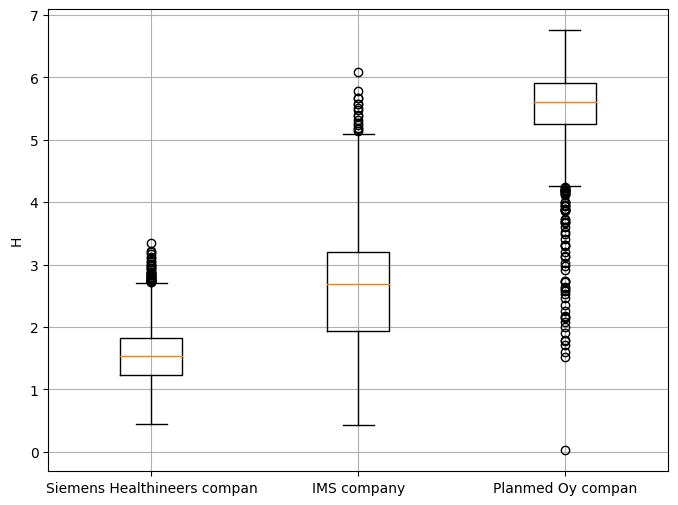

P-Value: 1.5541811640698218e-10
Ka një ndryshim domethënës midis dy grupeve.


In [48]:
Siemens_Healthineers_compan = np.concatenate([Mammomat_Inspiration_br1_entropy,
                         Mammomat_Inspiration_br2_entropy,
                         Mammomat_Inspiration_br3_entropy,
                         Mammomat_Inspiration_br4_entropy,
                         Mammomat_Inspiration_br5_entropy])


IMS_company = np.concatenate([GIOTTO_IMAGE_3DL_br1_entropy,
                         GIOTTO_IMAGE_3DL_br2_entropy,
                         GIOTTO_IMAGE_3DL_br3_entropy,
                         GIOTTO_IMAGE_3DL_br4_entropy,
                         GIOTTO_IMAGE_3DL_br5_entropy,
                         GIOTTO_CLASS_br1_entropy,
                         GIOTTO_CLASS_br2_entropy,
                         GIOTTO_CLASS_br3_entropy,
                         GIOTTO_CLASS_br4_entropy,
                         GIOTTO_CLASS_br5_entropy,
                         Saudi_Arabias_data_br1_entropy,
                         Saudi_Arabias_data_br2_entropy,
                         Saudi_Arabias_data_br3_entropy,
                         Saudi_Arabias_data_br4_entropy,
                         Saudi_Arabias_data_br5_entropy])

Planmed_Oy_company = np.concatenate([Planmed_Nuance_br1_entropy,
                         Planmed_Nuance_br2_entropy,
                         Planmed_Nuance_br3_entropy,
                         Planmed_Nuance_br4_entropy,
                         Planmed_Nuance_br5_entropy])


# Boxplot për krahasim
plt.figure(figsize=(8, 6))
plt.boxplot([Siemens_Healthineers_compan, IMS_company, Planmed_Oy_company], labels=['Siemens Healthineers compan', 'IMS company', 'Planmed Oy compan'])
plt.ylabel("H")
plt.grid(True)
plt.show()

# Llogaritja e p-value me Mann-Whitney U test 
stat, p_value = mannwhitneyu(entropy_classe_normal, entropy_classe_malignant, alternative='two-sided')

print(f"P-Value: {p_value}")

# Interpretimi
if p_value < 0.05:
    print("Ka një ndryshim domethënës midis dy grupeve.")
else:
    print("Nuk ka një ndryshim domethënës midis dy grupeve.")


C:\Users\Perdorues\AppData\Local\Temp\ipykernel_26916\1620300390.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Company', y='Entropy', data=df, palette=['#1f77b4', '#ff7f0e', '#2ca02c'])  # blu, portokalli, jeshile


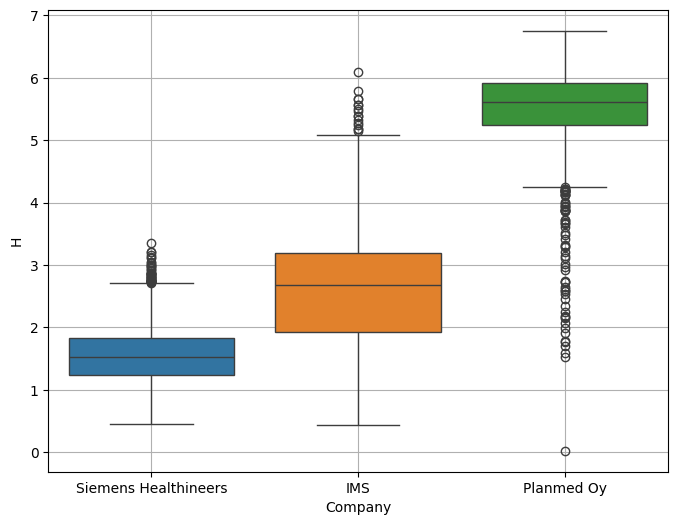

In [53]:
#  vizualizimi me ngjyra
data = {
    'Entropy': np.concatenate([Siemens_Healthineers_compan, IMS_company, Planmed_Oy_company]),
    'Company': (['Siemens Healthineers'] * len(Siemens_Healthineers_compan)) +
               (['IMS'] * len(IMS_company)) +
               (['Planmed Oy'] * len(Planmed_Oy_company))
}

df = pd.DataFrame(data)

plt.figure(figsize=(8, 6))
sns.boxplot(x='Company', y='Entropy', data=df, palette=['#1f77b4', '#ff7f0e', '#2ca02c'])  # blu, portokalli, jeshile
plt.ylabel("H")
plt.grid(True)
plt.show()


C:\Users\Perdorues\AppData\Local\Temp\ipykernel_26916\3330830086.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Company', y='Entropy', data=df, palette=['#1f77b4', '#ff7f0e', '#2ca02c'])


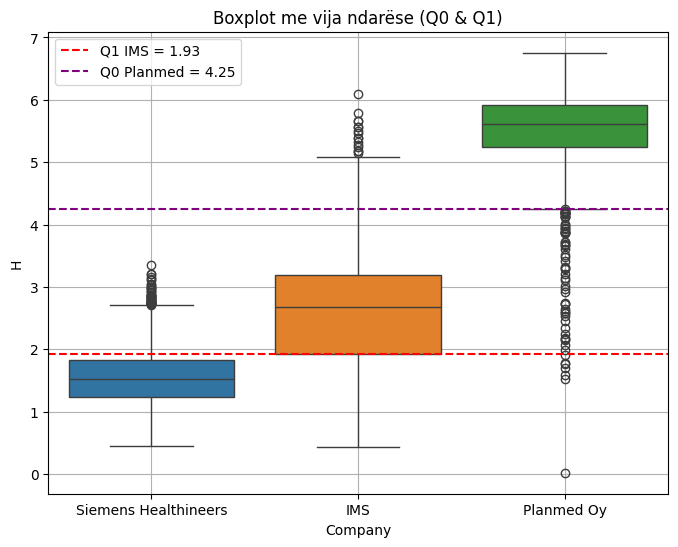

In [60]:
q1_ims = np.percentile(IMS_company, 25)

# 1. Llogarit IQR (Interquartile Range)
q1 = np.percentile(Planmed_Oy_company, 25)
q3 = np.percentile(Planmed_Oy_company, 75)
iqr = q3 - q1

# 2. Kufijtë për outlier-at
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# 3. Filtrimi i vlerave brenda kufijve
filtered_values = Planmed_Oy_company[(Planmed_Oy_company >= lower_bound) & (Planmed_Oy_company <= upper_bound)]

# 4. Q0 pa outliers
q0_planmed = np.min(filtered_values)

plt.figure(figsize=(8, 6))
sns.boxplot(x='Company', y='Entropy', data=df, palette=['#1f77b4', '#ff7f0e', '#2ca02c'])

# Shto vijat ndarëse
plt.axhline(q1_ims, color='red', linestyle='--', label=f'Q1 IMS = {q1_ims:.2f}')
plt.axhline(q0_planmed, color='purple', linestyle='--', label=f'Q0 Planmed = {q0_planmed:.2f}')

plt.ylabel("H")
plt.title("Boxplot me vija ndarëse (Q0 & Q1)")
plt.legend()
plt.grid(True)
plt.show()


In [61]:
# Funksion për të ndarë sipas zonave
def count_in_zones(data, q0, q1):
    zone1 = np.sum(data < q0)
    zone2 = np.sum((data >= q0) & (data < q1))
    zone3 = np.sum(data >= q1)
    return zone1, zone2, zone3

# Llogarit për secilën kompani
zones_siemens = count_in_zones(Siemens_Healthineers_compan, q1_ims, q0_planmed)
zones_ims = count_in_zones(IMS_company, q1_ims, q0_planmed)
zones_planmed = count_in_zones(Planmed_Oy_company, q1_ims, q0_planmed)

# Shfaq rezultatet
print(f"Vlerat në zona për Siemens Healthineers: Zona 1={zones_siemens[0]}, Zona 2={zones_siemens[1]}, Zona 3={zones_siemens[2]}")
print(f"Vlerat në zona për IMS: Zona 1={zones_ims[0]}, Zona 2={zones_ims[1]}, Zona 3={zones_ims[2]}")
print(f"Vlerat në zona për Planmed Oy: Zona 1={zones_planmed[0]}, Zona 2={zones_planmed[1]}, Zona 3={zones_planmed[2]}")


Vlerat në zona për Siemens Healthineers: Zona 1=6623, Zona 2=1423, Zona 3=0
Vlerat në zona për IMS: Zona 1=559, Zona 2=1627, Zona 3=49
Vlerat në zona për Planmed Oy: Zona 1=7, Zona 2=61, Zona 3=3728


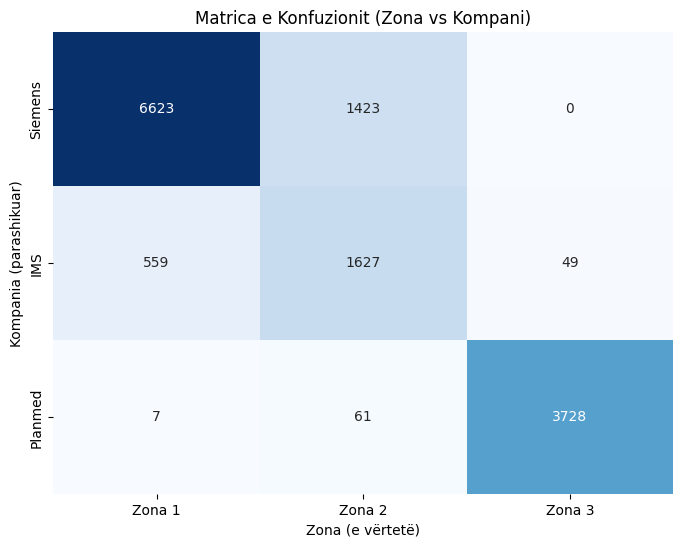

In [62]:
# Të dhënat për zonat dhe kompanitë
data = {
    'Zona 1': [6623, 559, 7],
    'Zona 2': [1423, 1627, 61],
    'Zona 3': [0, 49, 3728]
}

# Emrat e kompanive (predikimet)
companies = ['Siemens', 'IMS', 'Planmed']

# Krijimi i DataFrame-it si matricë konfuzioni
conf_matrix = pd.DataFrame(data, index=companies)

# Vizualizimi me heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Matrica e Konfuzionit (Zona vs Kompani)")
plt.xlabel("Zona (e vërtetë)")
plt.ylabel("Kompania (parashikuar)")
plt.show()

In [67]:
# Të dhënat për matricën e konfuzionit
D = np.array([
    [6623, 1423,    0],   # Siemens
    [ 559, 1627,   49],   # IMS
    [   7,   61, 3728]    # Planmed
])

# Llogaritja e saktësisë
correct = D[0, 0] + D[1, 1] + D[2, 2]  # elementët në diagonale
total = np.sum(D)

accuracy = correct / total
print(f"Saktësia: {accuracy:.4f}")


Saktësia: 0.8509


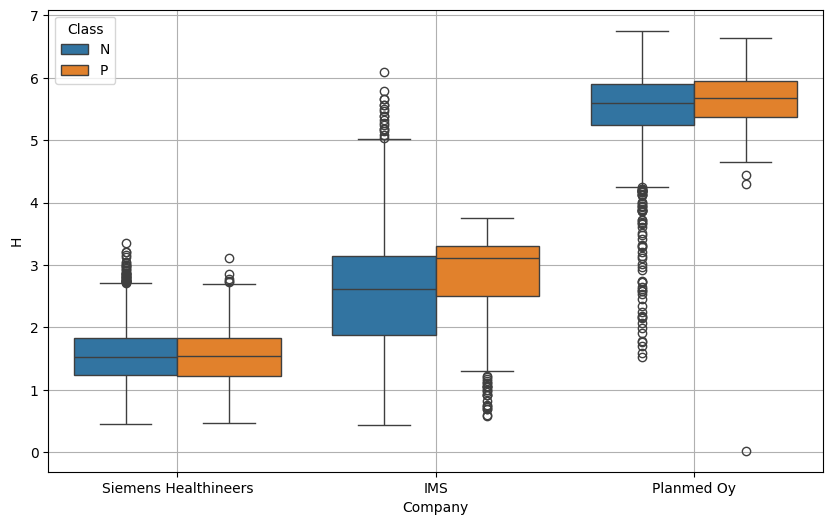

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Krijimi i një DataFrame për secilin grup (N dhe P)
data = {
    'Entropy': np.concatenate([Siemens_Healthineers_compan_N, Siemens_Healthineers_compan_P,
                               IMS_company_N, IMS_company_P, Planmed_Oy_company_N, Planmed_Oy_company_P]),
    'Class': (['N'] * len(Siemens_Healthineers_compan_N)) + (['P'] * len(Siemens_Healthineers_compan_P)) +
             (['N'] * len(IMS_company_N)) + (['P'] * len(IMS_company_P)) +
             (['N'] * len(Planmed_Oy_company_N)) + (['P'] * len(Planmed_Oy_company_P)),
    'Company': (['Siemens Healthineers'] * len(Siemens_Healthineers_compan_N)) +
               (['Siemens Healthineers'] * len(Siemens_Healthineers_compan_P)) +
               (['IMS'] * len(IMS_company_N)) +
               (['IMS'] * len(IMS_company_P)) +
               (['Planmed Oy'] * len(Planmed_Oy_company_N)) +
               (['Planmed Oy'] * len(Planmed_Oy_company_P))
}

df = pd.DataFrame(data)

# Krijimi i boxplot për secilën kompani dhe grupin N/P
plt.figure(figsize=(10, 6))
sns.boxplot(x='Company', y='Entropy', hue='Class', data=df, palette=['#1f77b4', '#ff7f0e'])
plt.ylabel("H")
plt.grid(True)
plt.show()


### ADH calculation For Saudi Arabian Dataset

In [103]:
Saudi_Arabias_data_CC = Saudi_Arabias_data.loc[Saudi_Arabias_data["Breast View"] == 'CC']
Saudi_Arabias_data_MLO = Saudi_Arabias_data.loc[Saudi_Arabias_data["Breast View"] == 'MLO']

len(Saudi_Arabias_data_MLO)

672

In [82]:
Saudi_Arabias_data_CC

,Staty_date,PatientID,Patient age,Breast type,Breast View,Density,Assesment,Path
0,23-Apr-19,BC0026061,44,R,CC,51%-75%,BIRAD 3,mammograms/BIRAD 3/2019_BC0026061_ CC_R.dcm
2,23-Apr-19,BC0026061,44,L,CC,51%-75%,BIRAD 3,mammograms/BIRAD 3/2019_BC0026061_ CC_L.dcm
4,21-Apr-19,BC0025981,42,R,CC,51%-75%,BIRAD 1,mammograms/BIRAD 1/2019_BC0025981_ CC_R.dcm
6,21-Apr-19,BC0025981,42,L,CC,51%-75%,BIRAD 1,mammograms/BIRAD 1/2019_BC0025981_ CC_L.dcm
8,21-Apr-19,BC0026001,45,R,CC,0%-25%,BIRAD 3,mammograms/BIRAD 3/2019_BC0026001_ CC_R.dcm
...,...,...,...,...,...,...,...,...
1334,20-Oct-14,BC010501,62,L,CC,0%-25%,BIRAD 1,mammograms/BIRAD 1/2013_BC010501_ CC_L.dcm
1336,11-Sep-14,BC009942,54,R,CC,26%-50%,BIRAD 1,mammograms/BIRAD 1/2013_BC009942_ CC_R.dcm
1338,11-Sep-14,BC009942,54,L,CC,26%-50%,BIRAD 1,mammograms/BIRAD 1/2013_BC009942_ CC_L.dcm
1340,3-Sep-14,BC010241,52,R,CC,0%-25%,BIRAD 1,mammograms/BIRAD 1/2013_BC010241_ CC_R.dcm


In [88]:
images = Saudi_Arabias_data_CC.shape[0]
cause = int(images / 2)

normal = 0
malignant = 0

for k in range(cause):  # Number of cases
    if Saudi_Arabias_data_CC.iloc[2*k]["Assesment"] in ['BIRAD 1', 'BIRAD 2', 'BIRAD 3']:
        label1 = 'normal'
    else:
        label1 = 'malignant'
        
    if Saudi_Arabias_data_CC.iloc[2*k+1]["Assesment"] in ['BIRAD 1', 'BIRAD 2', 'BIRAD 3']:
        label2 = 'normal'
    else:
        label2 = 'malignant'

    if label1 == 'normal' and label2 == 'normal':
        normal += 1
    else:
        malignant += 1

print(f'Normal: {normal}')
print(f'Malignant: {malignant}')


Normal: 308
Malignant: 28


In [91]:
def entropy_image(Saudi_Arabias_data_iloc_i_k, base_path='E:/PhD/Saudi_Arabia/'):
    file_path = Saudi_Arabias_data_iloc_i_k.replace('.dcm', '.jpg')
        
    image_path = os.path.join(base_path, file_path)
    if os.path.exists(image_path):
        # Leximi i imazhit
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if len(image.shape) == 3:
            image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        energy_im = energy(image.astype(int))
            
        return shannon_entropy(energy_im)
        

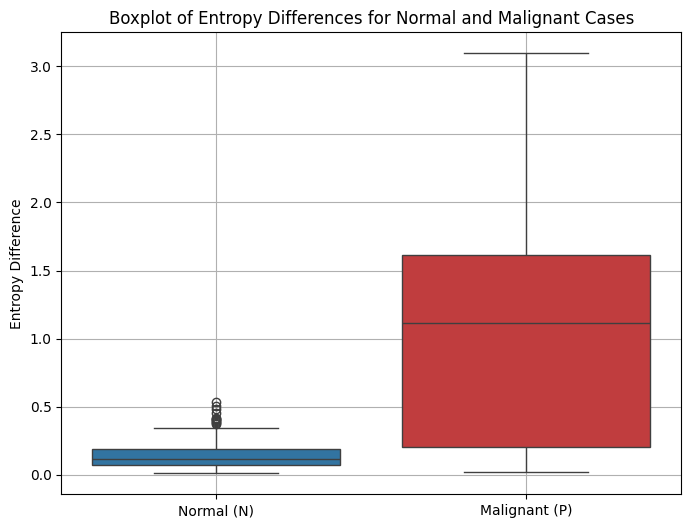

In [105]:
# Vizualizimi me boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(data=[N, P], palette=["#1f77b4", "#d62728"])
plt.xticks([0, 1], ['Normal (N)', 'Malignant (P)'])
plt.ylabel('Entropy Difference')
plt.title('Boxplot of Entropy Differences for Normal and Malignant Cases')
plt.grid(True)
plt.show()

In [106]:
images = Saudi_Arabias_data_CC.shape[0]
cause = int(images / 2)

normal = 0
malignant = 0

N = []
P = []

N1 = []
P1 = []

N2 = []
P2 = []
for k in range(cause):
    label1 = 'normal' if Saudi_Arabias_data_CC.iloc[2*k]["Assesment"] in ['BIRAD 1', 'BIRAD 2', 'BIRAD 3'] else 'malignant'
    label2 = 'normal' if Saudi_Arabias_data_CC.iloc[2*k+1]["Assesment"] in ['BIRAD 1', 'BIRAD 2', 'BIRAD 3'] else 'malignant'

    try:
        elcc = entropy_image(Saudi_Arabias_data_CC.iloc[2*k, 7], base_path='E:/PhD/Saudi_Arabia/')
        ercc = entropy_image(Saudi_Arabias_data_CC.iloc[2*k+1, 7], base_path='E:/PhD/Saudi_Arabia/')
        elmlo = entropy_image(Saudi_Arabias_data_MLO.iloc[2*k, 7], base_path='E:/PhD/Saudi_Arabia/')
        ermlo = entropy_image(Saudi_Arabias_data_MLO.iloc[2*k+1, 7], base_path='E:/PhD/Saudi_Arabia/')
        # Skip if any entropy is None
        if e1 is None or e2 is None:
            print(f'Skipping case {k} due to missing entropy value.')
            continue

        entropy_cc = np.abs(elcc - ercc)
        entropy_mlo = np.abs(elmlo - ermlo)
        
        mean_entropy = (entropy_cc + entropy_mlo)/2
        max_ent = max(entropy_cc, entropy_cc)
        min_ent = min(entropy_cc, entropy_cc)
        
        if label1 == 'normal' and label2 == 'normal':
            N.append(mean_entropy)
            N1.append(max_ent)
            N2.append(min_ent)
           
            normal += 1
        else:
            P.append(mean_entropy)
            P1.append(max_ent)
            P2.append(min_ent)
            malignant += 1

    except Exception as e:
        print(f'Error processing case {k}: {e}')
        continue

    print(f'{k} of {cause} are processed.')

print(f'Normal: {normal}')
print(f'Malignant: {malignant}')


0 of 336 are processed.
1 of 336 are processed.
2 of 336 are processed.
3 of 336 are processed.
4 of 336 are processed.
5 of 336 are processed.
6 of 336 are processed.
7 of 336 are processed.
8 of 336 are processed.
9 of 336 are processed.
10 of 336 are processed.
11 of 336 are processed.
12 of 336 are processed.
13 of 336 are processed.
14 of 336 are processed.
Error processing case 15: unsupported operand type(s) for -: 'float' and 'NoneType'
16 of 336 are processed.
17 of 336 are processed.
Error processing case 18: unsupported operand type(s) for -: 'NoneType' and 'NoneType'
19 of 336 are processed.
20 of 336 are processed.
21 of 336 are processed.
22 of 336 are processed.
23 of 336 are processed.
24 of 336 are processed.
Error processing case 25: unsupported operand type(s) for -: 'NoneType' and 'NoneType'
Error processing case 26: unsupported operand type(s) for -: 'NoneType' and 'NoneType'
27 of 336 are processed.
28 of 336 are processed.
Error processing case 29: unsupported op

287 of 336 are processed.
288 of 336 are processed.
289 of 336 are processed.
290 of 336 are processed.
291 of 336 are processed.
292 of 336 are processed.
293 of 336 are processed.
294 of 336 are processed.
295 of 336 are processed.
296 of 336 are processed.
297 of 336 are processed.
298 of 336 are processed.
299 of 336 are processed.
300 of 336 are processed.
301 of 336 are processed.
302 of 336 are processed.
303 of 336 are processed.
Error processing case 304: unsupported operand type(s) for -: 'float' and 'NoneType'
305 of 336 are processed.
306 of 336 are processed.
307 of 336 are processed.
308 of 336 are processed.
309 of 336 are processed.
310 of 336 are processed.
311 of 336 are processed.
312 of 336 are processed.
313 of 336 are processed.
314 of 336 are processed.
315 of 336 are processed.
316 of 336 are processed.
317 of 336 are processed.
318 of 336 are processed.
319 of 336 are processed.
320 of 336 are processed.
321 of 336 are processed.
322 of 336 are processed.
323 o

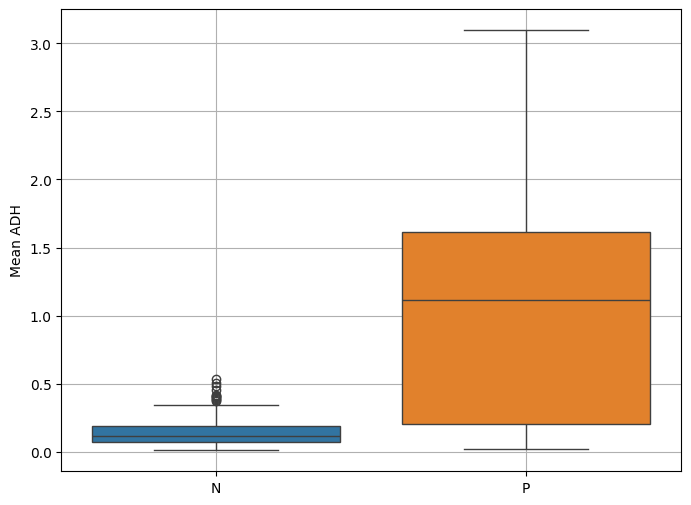

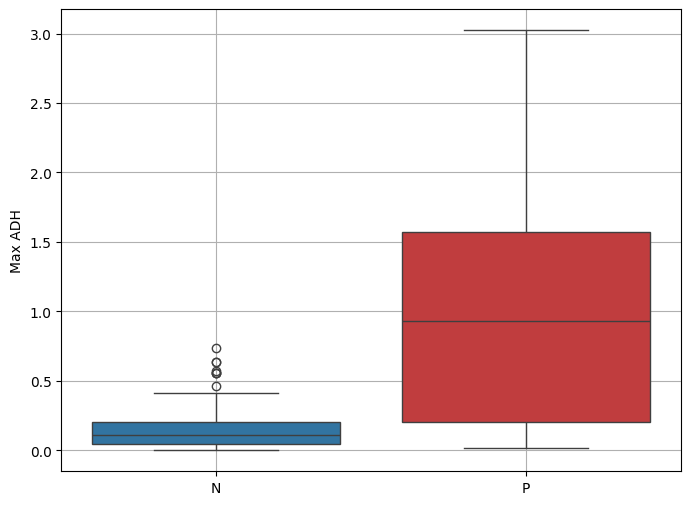

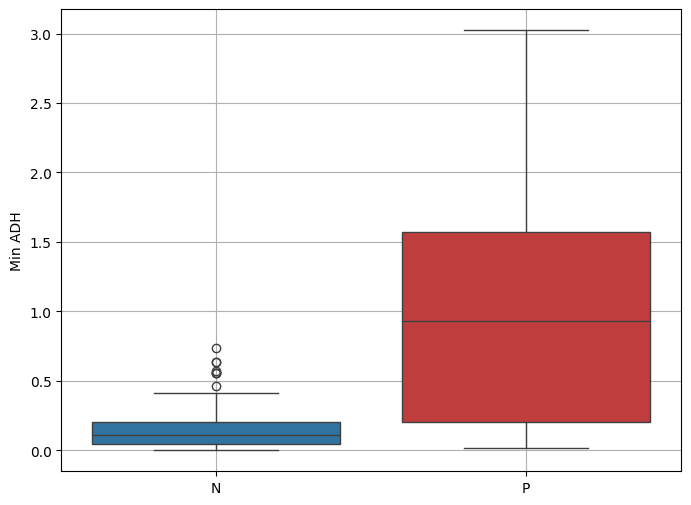

In [107]:
# Vizualizimi me boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(data=[N, P])
plt.xticks([0, 1], ['N', 'P'])
plt.ylabel('Mean ADH')
plt.grid(True)
plt.show()
# Vizualizimi me boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(data=[N1, P1], palette=["#1f77b4", "#d62728"])
plt.xticks([0, 1], ['N', 'P'])
plt.ylabel('Max ADH')
plt.grid(True)
plt.show()
# Vizualizimi me boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(data=[N2, P2], palette=["#1f77b4", "#d62728"])
plt.xticks([0, 1], ['N', 'P'])
plt.ylabel('Min ADH')
plt.grid(True)
plt.show()